# Восстановление золота из руды

Подготовьте прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. Используйте данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Вам нужно:

1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.

Чтобы выполнить проект, обращайтесь к библиотекам *pandas*, *matplotlib* и *sklearn.* Вам поможет их документация.

## Подготовка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time 
from tqdm import tqdm                                  # для слежения за прогрессом
from sklearn.preprocessing import StandardScaler       # для стандартизации (масштабирования) данных
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score             # для вычисления accuracy
from sklearn.metrics import recall_score               # для вычисления полноты
from sklearn.metrics import precision_score            # для вычисления точности
from sklearn.metrics import f1_score                   # для вычисления f-1 меры
from sklearn.metrics import confusion_matrix           # для расчета матрицы ошибок
from sklearn.metrics import make_scorer                # для создания собственных метрик
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import GridSearchCV       # для подбора лучших парметров модели
from sklearn.model_selection import cross_val_score    # для кроссвалидации  
from sklearn.utils import shuffle                      # для увеличения или уменьшения выборки 
from sklearn.dummy import DummyRegressor               # для константной модели

import warnings
warnings.filterwarnings('ignore')

In [2]:
RANDOM_STATE = 12345

### Загрузка данных

In [3]:
# общий путь
try:
    data_train = pd.read_csv('/datasets/gold_recovery_train_new.csv')
    data_test = pd.read_csv('/datasets/gold_recovery_test_new.csv')
    data = pd.read_csv('/datasets/gold_recovery_full_new.csv')
# локальный путь    
except:
    data_train = pd.read_csv('D:/Git/YandexPracticum/Gold_mining/gold_recovery_train_new.csv')
    data_test = pd.read_csv('D:/Git/YandexPracticum/Gold_mining/gold_recovery_test_new.csv')
    data = pd.read_csv('D:/Git/YandexPracticum/Gold_mining/gold_recovery_full_new.csv')


### Описание данных

**Технологический процесс**

- `Rougher feed` — исходное сырье
- `Rougher additions` (или reagent additions) — флотационные реагенты: Xanthate, Sulphate, Depressant
  - `Xanthate **`— ксантогенат (промотер, или активатор флотации);
  - `Sulphate` — сульфат (на данном производстве сульфид натрия);
  - `Depressant` — депрессант (силикат натрия).
- `Rougher process` (англ. «грубый процесс») — флотация
- `Rougher tails` — отвальные хвосты
- `Float banks` — флотационная установка
- `Cleaner process` — очистка
- `Rougher Au` — черновой концентрат золота
- `Final Au` — финальный концентрат золота

**Параметры этапов**

- `air amount` — объём воздуха
- `fluid levels` — уровень жидкости
- `feed size` — размер гранул сырья
- `feed rate` — скорость подачи

### Наименование признаков

Наименование признаков:
`[этап].[тип_параметра].[название_параметра]`

Пример:` rougher.input.feed_ag`

Значения для блока [этап]:
- `rougher` — флотация
- `primary_cleaner` — первичная очистка
- `secondary_cleaner` — вторичная очистка
- `final` — финальные характеристики

Значения для блока [тип_параметра]:
- `input` — параметры сырья
- `output` — параметры продукта
- `state` — параметры, характеризующие текущее состояние этапа
- `calculation` — расчётные характеристики

### Исследованиe данных

**Посмотрим на размеры датасетов:**

In [4]:
data.shape

(19439, 87)

In [5]:
data_train.shape

(14149, 87)

In [6]:
data_test.shape

(5290, 53)

In [7]:
print('Размер тренировочной выборки:', (len(data_train) / len(data)) * 100, '%')
print('Размер тестовой выборки:', (len(data_test) / len(data)) * 100, '%')

Размер тренировочной выборки: 72.78666598076032 %
Размер тестовой выборки: 27.21333401923967 %


**Количество столбцов значительное, зададим возможность вывода всех столбцов датасета**

In [8]:
pd.set_option('display.max_columns', len(data.columns))

In [9]:
data.head(3)

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,10.128295,7.25,0.988759,8.547551,10.389648,19.529297,34.174427,14.936526,2.534912,7.476074,2.106679,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,11.500771,7.101074,28.029297,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,14.500184,4.694824,8.764648,2.606185,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,10.296251,7.25,1.002663,8.558743,10.

**Информация о данных**

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                19439 non-null  object 
 1   final.output.concentrate_ag                         19438 non-null  float64
 2   final.output.concentrate_pb                         19438 non-null  float64
 3   final.output.concentrate_sol                        19228 non-null  float64
 4   final.output.concentrate_au                         19439 non-null  float64
 5   final.output.recovery                               19439 non-null  float64
 6   final.output.tail_ag                                19438 non-null  float64
 7   final.output.tail_pb                                19338 non-null  float64
 8   final.output.tail_sol                               19433 non-null  float64


In [11]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14149 non-null  object 
 1   final.output.concentrate_ag                         14148 non-null  float64
 2   final.output.concentrate_pb                         14148 non-null  float64
 3   final.output.concentrate_sol                        13938 non-null  float64
 4   final.output.concentrate_au                         14149 non-null  float64
 5   final.output.recovery                               14149 non-null  float64
 6   final.output.tail_ag                                14149 non-null  float64
 7   final.output.tail_pb                                14049 non-null  float64
 8   final.output.tail_sol                               14144 non-null  float64


In [12]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5290 entries, 0 to 5289
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5290 non-null   object 
 1   primary_cleaner.input.sulfate               5286 non-null   float64
 2   primary_cleaner.input.depressant            5285 non-null   float64
 3   primary_cleaner.input.feed_size             5290 non-null   float64
 4   primary_cleaner.input.xanthate              5286 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64
 10  primary_clea

<div style="border:solid gray 2px; padding: 20px">
    Данные имеют пропуски, тип данных для даты не соответсвует требуемому для дальнейшей работы</div>

**Проверка расчета эффективности обогащения**

In [13]:
def rougher_output_recovery(data):
    C = data_train['rougher.output.concentrate_au']
    F = data_train['rougher.input.feed_au']
    T = data_train['rougher.output.tail_au']
    recovery = (C * (F-T)) / (F *(C-T)) * 100
    return recovery

In [14]:
df_rougher_output_recovery = pd.DataFrame(data = data_train['rougher.output.recovery'])
df_rougher_output_recovery['check'] = rougher_output_recovery(data_train)
df_rougher_output_recovery

,rougher.output.recovery,check
0,87.107763,87.107763
1,86.843261,86.843261
2,86.842308,86.842308
3,87.226430,87.226430
4,86.688794,86.688794
...,...,...
14144,89.574376,89.574376
14145,87.724007,87.724007
14146,88.890579,88.890579
14147,89.858126,89.858126


Проверка:

In [15]:
df_rougher_output_recovery[(round(df_rougher_output_recovery['rougher.output.recovery'], 9)) \
                           != (round(df_rougher_output_recovery['check'], 9))]

,rougher.output.recovery,check
1984,69.940017,69.940017


Расчет абсолютных отклонений между фактическим и прогнозирумым значением

In [16]:
df_rougher_output_recovery['$\Delta$rec'] = abs(df_rougher_output_recovery['rougher.output.recovery'] \
                                       - df_rougher_output_recovery['check'])
df_rougher_output_recovery

,rougher.output.recovery,check,$\Delta$rec
0,87.107763,87.107763,0.000000e+00
1,86.843261,86.843261,1.421085e-14
2,86.842308,86.842308,1.421085e-14
3,87.226430,87.226430,0.000000e+00
4,86.688794,86.688794,0.000000e+00
...,...,...,...
14144,89.574376,89.574376,0.000000e+00
14145,87.724007,87.724007,0.000000e+00
14146,88.890579,88.890579,1.421085e-14
14147,89.858126,89.858126,0.000000e+00


Эффективность обогащения расчитаная по формуле отличается у некоторых значений не более чем на 0,000_000_001 (одну миллионную долю), расчитаем МАЕ

In [17]:
mae = df_rougher_output_recovery['$\Delta$rec'].sum() / len(df_rougher_output_recovery['$\Delta$rec'])
print('MAE: ', mae)

MAE:  9.73512347450521e-15


<div style="border:solid gray 2px; padding: 20px">
MAE почти ноль. Эффективность обогащения расчитана правильно. </div>

Изменим формат даты с **object** на **datetime** 

In [18]:
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%dT%H:%M:%S')
data_train['date'] = pd.to_datetime(data_train['date'], format='%Y-%m-%dT%H:%M:%S')
data_test['date'] = pd.to_datetime(data_test['date'], format='%Y-%m-%dT%H:%M:%S')

**Ищем дубликаты строк**

In [19]:
data.duplicated().sum() + data_train.duplicated().sum() + data_test.duplicated().sum()

0

**Ищем дубликаты в столбцах**

In [20]:
total = 0
for column in data.columns:
    result = data[column].duplicated().sum()
    total += result
print('Найдено', total, 'одинаковых значений')  

Найдено 28427 одинаковых значений


**Определим в каких столбцах находятся дубли**

In [21]:
col = []
for column in data.columns:
    if data[column].duplicated().sum() > 2:
        col.append(column)
col   

['final.output.concentrate_ag',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.concentrate_au',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'final.output.tail_au',
 'primary_cleaner.input.sulfate',
 'primary_cleaner.input.depressant',
 'primary_cleaner.input.feed_size',
 'primary_cleaner.input.xanthate',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.state.floatbank8_a_air',
 'primary_cleaner.state.floatbank8_b_air',
 'rougher.calculation.au_pb_ratio',
 'rougher.input.feed_ag',
 'rougher.input.feed_pb',
 'rougher.input.feed_rate',
 'rougher.input.feed_size',
 'rougher.input.feed_sol',
 'rougher.input.feed_au',
 'rougher

**Проверим на дубли первый столбец**

In [22]:
data['final.output.concentrate_ag'].value_counts()

0.000000    98
5.925380    11
3.554558     7
3.572025     6
5.413548     5
            ..
5.251861     1
5.541594     1
5.658072     1
5.931221     1
3.598375     1
Name: final.output.concentrate_ag, Length: 19307, dtype: int64

In [23]:
data['primary_cleaner.output.tail_pb'].value_counts()

0.000000    124
0.887634     11
2.972412      6
4.257324      5
6.538574      3
           ... 
3.421010      1
3.258878      1
3.177579      1
3.406231      1
6.084287      1
Name: primary_cleaner.output.tail_pb, Length: 19270, dtype: int64

**Определим количество нулевых значений во всем датафрейме**

In [24]:
total = 0
for column in data.columns:
    result = data.loc[data.loc[:,'primary_cleaner.output.tail_pb'] == 0]['primary_cleaner.output.tail_pb'].count()
    total += result

total

10788

<div style="border:solid gray 2px; padding: 20px">
В основной выборке находится 10788 значений = 0.</div>

**Список всех столбцов данных**

In [25]:
columns = data.columns

**Таблица пропущенных значений**

In [26]:
df_isna = pd.DataFrame(index=columns, data=data.isna().sum(), columns=['data'])
df_train_isna = pd.DataFrame(index=columns, data=data_train.isna().sum(), columns=['data_train'])
df_test_isna = pd.DataFrame(index=columns, data=data_test.isna().sum(), columns=['data_test'])
df_isna = pd.concat([df_isna, df_train_isna, df_test_isna], axis = 1, ignore_index=False).fillna(0)

for i in df_isna.index:
    if df_isna.loc[i].sum() == 0:
        df_isna = df_isna.drop(i, axis=0)          

**График пропущенных значений**

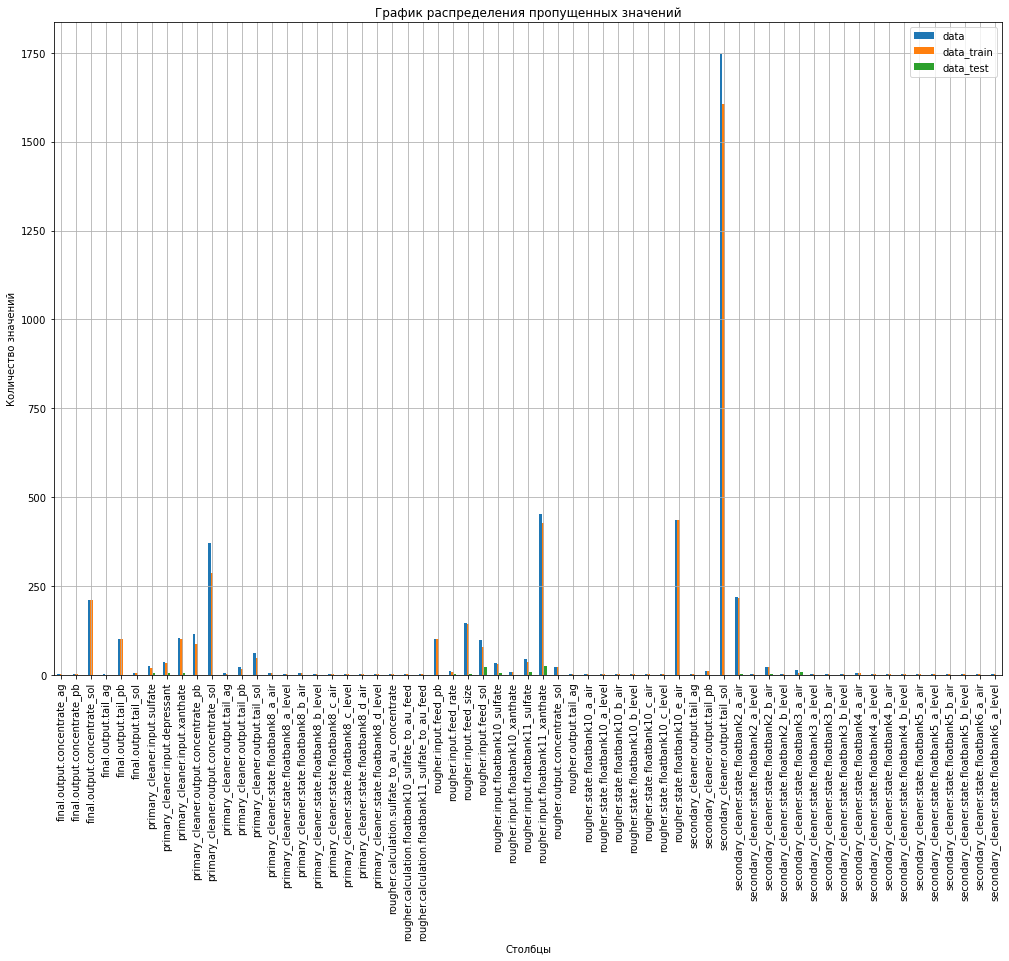

In [27]:
df_isna.plot(kind='bar', figsize=(17, 12), grid=True, title='График распределения пропущенных значений',
                                                      xlabel='Столбцы',
                                                      ylabel='Количество значений')
plt.show();

<div style="border:solid gray 2px; padding: 20px">
Столбцы с целевыми значениями <b>recovery</b> и столбцы со значениями для расчета <b>recovery</b> не содержат пропущенных значений.</div>

**Считаем долю строк с пропусками**

In [28]:
len(data[data.isna().any(1)]) / len(data) * 100

17.207675291938887

<div style="border:solid gray 2px; padding: 20px">
После изучение пропущенных значений выяснилось, что таковые отсутствуют в столбцах с целевыми признаками. Объем пропущенных значений составляет 17,2% от всех строк, слишком большой объем данных для удаления. Еще 8,5% строк содержат ячейки с нулевым значением. Учитывая технологический процесс при котором ежечасно для обработки подается тарированная партия руды, можно предположить, что характеристики соседних партий будут иметь минимальные отличия, поэтому пропущенные и нулевые значения возможно заменить ближайшими значениями. </div>

### Предобработка данных

**Заменяем отсутствующие значения на значения ближайших соседей, т.к. соседние по времени параметры часто похожи**

In [29]:
data = data.ffill().bfill()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype         
---  ------                                              --------------  -----         
 0   date                                                19439 non-null  datetime64[ns]
 1   final.output.concentrate_ag                         19439 non-null  float64       
 2   final.output.concentrate_pb                         19439 non-null  float64       
 3   final.output.concentrate_sol                        19439 non-null  float64       
 4   final.output.concentrate_au                         19439 non-null  float64       
 5   final.output.recovery                               19439 non-null  float64       
 6   final.output.tail_ag                                19439 non-null  float64       
 7   final.output.tail_pb                                19439 non-null  float64       
 8   final.

In [30]:
data[data.isin([0]).any(axis=1)]

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
19,2016-01-15 19:00:00,5.658943,10.436002,5.942418,42.509402,70.348300,10.232392,1.174845,19.498566,2.272460,149.998260,12.509947,7.25,0.997030,0.000000,0.000000,0.000000,0.000000,14.915949,2.702527,7.784534,2.013487,1599.617983,-499.527131,1599.389604,-499.554869,1600.441370,-500.503609,1601.900702,-500.129123,41959.818540,3507.941540,3499.552368,2.448851,6.046063,2.777324,571.766992,62.823127,40.381002,6.801254,14.812266,7.064468,14.814722,7.064408,10.788951,7.537074,26.092838,18.511902,86.241795,4.919573,0.739863,20.309714,1.369732,999.708593,-400.075046,1600.639292,-450.110961,1602.333794,-450.673170,1600.427078,-449.633484,1401.859581,-448.145152,1400.906088,-451.771497,12.708557,4.565723,9.997717,2.138772,25.999540,-500.152462,24.013000,-500.297031,24.022240,-499.329964,24.012891,-499.923981,14.001632,-509.808331,12.087669,-510.782166,10.032043,-499.128183,8.016140,-499.806844,13.949790,-600.140776
22,2016-01-15 22:00:00,6.118749,10.483007,6.546983,41.406172,69.823900,10.322077,1.270956,19.384247,2.245145,158.353434,14.020791,7.25,0.997999,0.000000,0

<div style="border:solid gray 2px; padding: 20px">
Строк с нулевыми значениями найдено 1660, это 8,5% всех строк, их тоже заполним предыдущим значением.</div>

**Заменим все значения = 0 в датафрейме на NaN, а потом заменим на значения ближайших соседей**

In [31]:
data = data.replace(0, np.nan)
data = data.ffill().bfill()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype         
---  ------                                              --------------  -----         
 0   date                                                19439 non-null  datetime64[ns]
 1   final.output.concentrate_ag                         19439 non-null  float64       
 2   final.output.concentrate_pb                         19439 non-null  float64       
 3   final.output.concentrate_sol                        19439 non-null  float64       
 4   final.output.concentrate_au                         19439 non-null  float64       
 5   final.output.recovery                               19439 non-null  float64       
 6   final.output.tail_ag                                19439 non-null  float64       
 7   final.output.tail_pb                                19439 non-null  float64       
 8   final.

**Найдем столбцы отсутствующие в тренировочной и тестовой выборке**

In [32]:
not_data_train_columns = []
for col in data.columns:
    if col not in data_train.columns:
        not_data_train_columns.append(col)
        
not_data_train_columns        

[]

**В тренировочной выборке столбцы совпадают с общей**

In [33]:
not_data_test_columns = []
for col in data.columns:
    if col not in data_test.columns:
        not_data_test_columns.append(col)
        
not_data_test_columns        

['final.output.concentrate_ag',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.concentrate_au',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'final.output.tail_au',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'primary_cleaner.output.tail_au',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.au_pb_ratio',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.concentrate_au',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_pb',
 'rougher.output.ta

<div style="border:solid gray 2px; padding: 20px">
Тестовая выборка не содержит данных о характеристиках хвостов и концентратов полученых после каждого этапа. По сути эти значения являются данными для расчета целевого признака. Тестовая выборка является набором признаков для проверки модели. Её необходимо дополнить двумя столбцами <b>'rougher.output.recovery'</b> и <b>'final.output.recovery'</b>.</div>

## Анализ данных

### Разделение параметров по этапам 

In [34]:
rougher_columns = columns[31:65]
primary_cleaner_columns = columns[11:30]
secondary_cleaner_columns = columns[66:87]
final_columns = columns[0:10]

In [35]:
rougher_columns

Index(['rougher.calculation.floatbank10_sulfate_to_au_feed',
       'rougher.calculation.floatbank11_sulfate_to_au_feed',
       'rougher.calculation.au_pb_ratio', 'rougher.input.feed_ag',
       'rougher.input.feed_pb', 'rougher.input.feed_rate',
       'rougher.input.feed_size', 'rougher.input.feed_sol',
       'rougher.input.feed_au', 'rougher.input.floatbank10_sulfate',
       'rougher.input.floatbank10_xanthate',
       'rougher.input.floatbank11_sulfate',
       'rougher.input.floatbank11_xanthate', 'rougher.output.concentrate_ag',
       'rougher.output.concentrate_pb', 'rougher.output.concentrate_sol',
       'rougher.output.concentrate_au', 'rougher.output.recovery',
       'rougher.output.tail_ag', 'rougher.output.tail_pb',
       'rougher.output.tail_sol', 'rougher.output.tail_au',
       'rougher.state.floatbank10_a_air', 'rougher.state.floatbank10_a_level',
       'rougher.state.floatbank10_b_air', 'rougher.state.floatbank10_b_level',
       'rougher.state.floatbank10_c_ai

**Анализ данных будем проводить в технологической последовательности**

### Этап флотации

**Фракция**

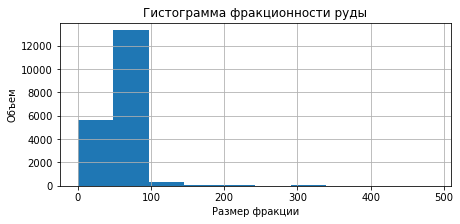

In [36]:
data['rougher.input.feed_size'].hist(figsize=(7,3))
plt.title('Гистограмма фракционности руды')
plt.xlabel('Размер фракции')
plt.ylabel('Объем')
plt.show();

<div style="border:solid gray 2px; padding: 20px">
    
Сырье перед началом обработки измельчается до фракции 0-100, значения больше 100 - допустимый процент содержания более крупных включений
</div>

**Скорость подачи**

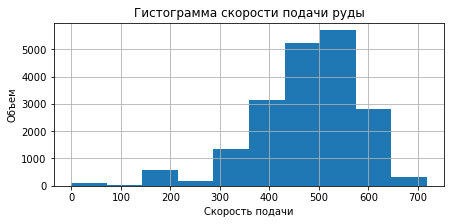

In [37]:
data['rougher.input.feed_rate'].hist(figsize=(7,3))
plt.title('Гистограмма скорости подачи руды')
plt.xlabel('Скорость подачи')
plt.ylabel('Объем')
plt.show();

<div style="border:solid gray 2px; padding: 20px">
Скорость подачи сырья в среднем составляет 450-550 ед/ч, небольшие значения скорее возникают в период загрузки и разгрузки линии
</div>    

**Характеристика руды**

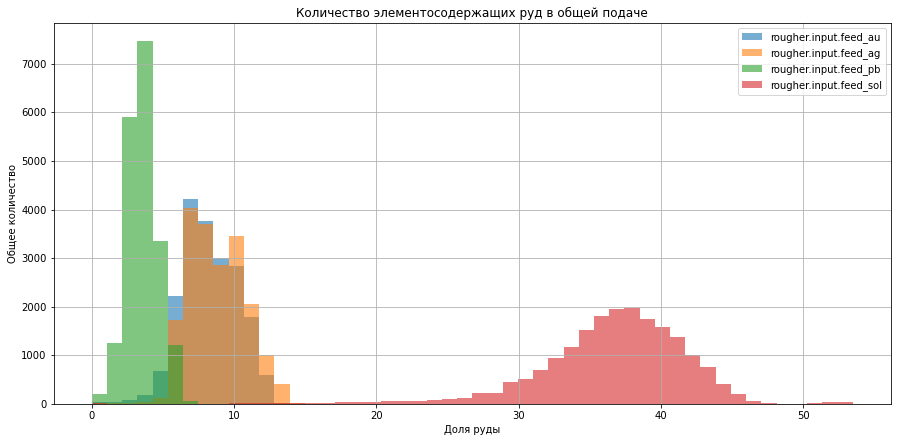

In [38]:
data[['rougher.input.feed_au',
      'rougher.input.feed_ag', 
      'rougher.input.feed_pb',
      'rougher.input.feed_sol']].plot(kind='hist', 
                                      figsize=(15,7), 
                                      alpha=0.6, 
                                      bins=50,
                                      grid=True)
plt.title('Количество элементосодержащих руд в общей подаче')
plt.xlabel('Доля руды')
plt.ylabel('Общее количество')
plt.show();

<div style="border:solid gray 2px; padding: 20px">
На графике видно, что в партии содержатся руды с разной концентрацией веществ, наиболее насыщеная руда с содержанием соли около 40%, по 10 долей у руд с серебром и золотом, наименее концентрированная руда со свинцом
</div>

**Флотационный процесс**

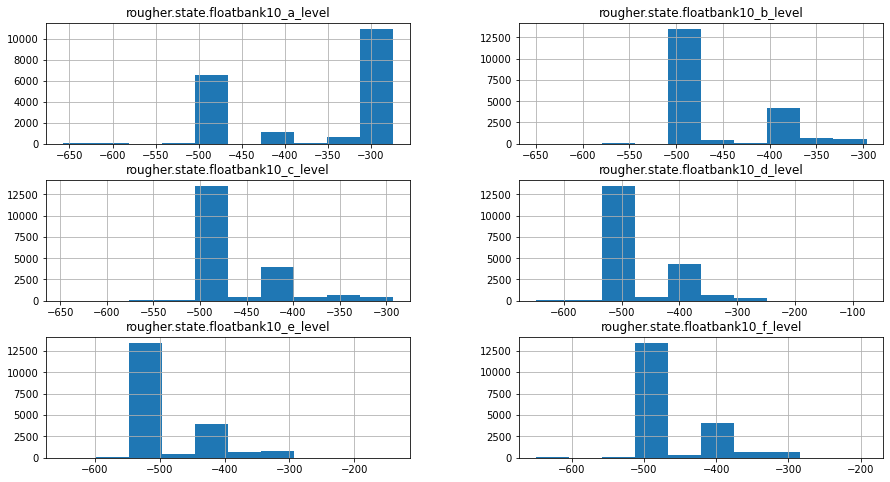

In [39]:
data[columns[[54,56,58,60,62,64]]].hist(figsize=(15,8))
plt.show();

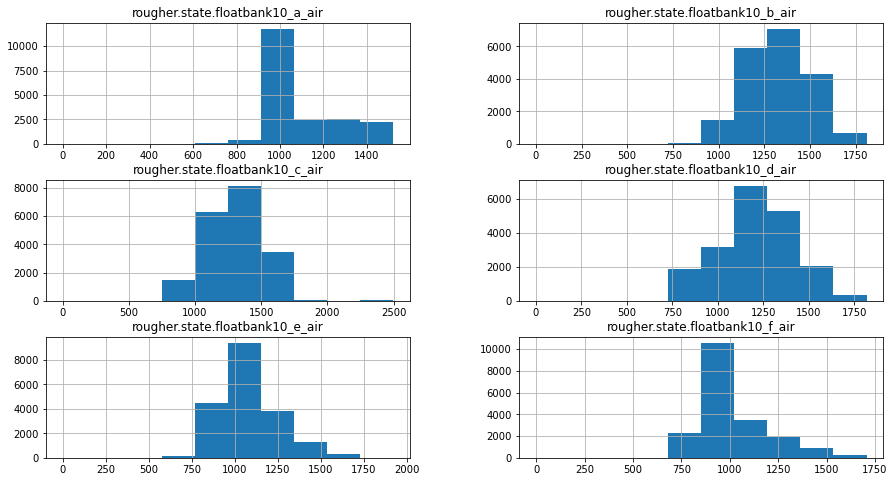

In [40]:
data[columns[[53,55,57,59,61,63]]].hist(figsize=(15,8))
plt.show();

**Хвосты**

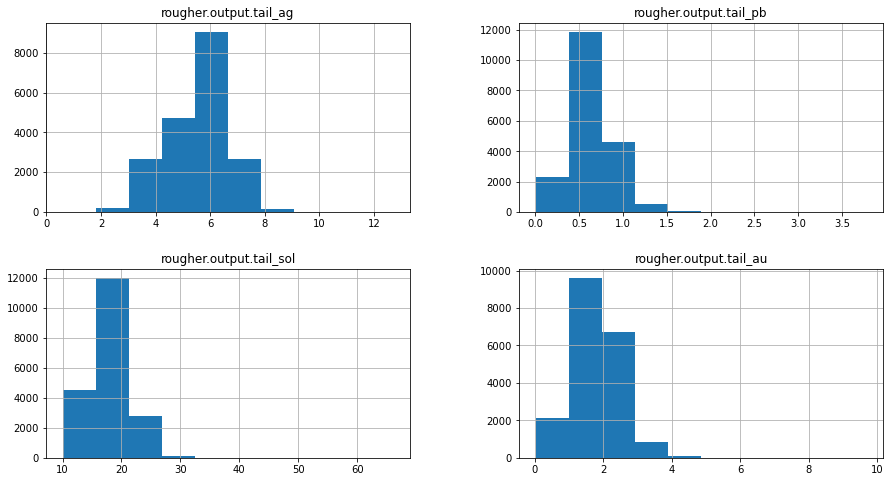

In [41]:
data[['rougher.output.tail_ag', 
      'rougher.output.tail_pb', 
      'rougher.output.tail_sol', 
      'rougher.output.tail_au']].hist(figsize=(15,8))
plt.show();

<div style="border:solid gray 2px; padding: 20px">
На графиках видно, что у данных нормально распределение. Небольшие показатели подтверждают, что в остатках содержится малое количество продукта.
</div>    

**Реагенты**

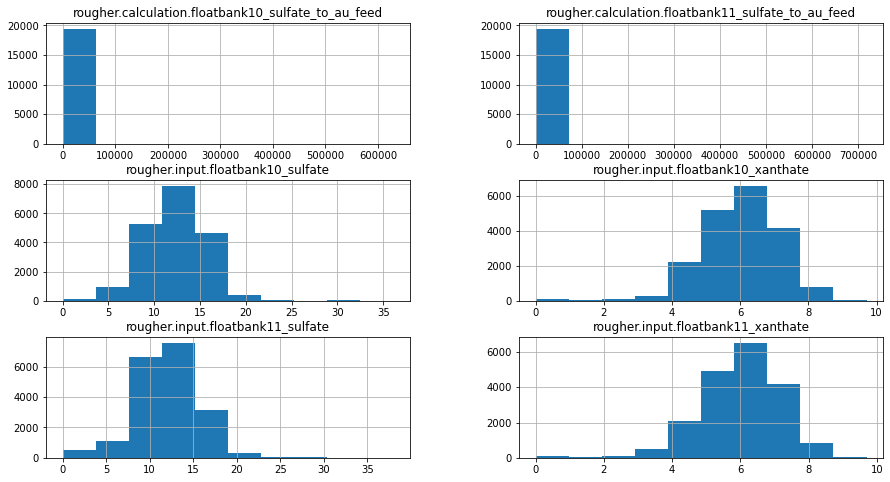

In [42]:
data[columns[[31,32,40,41,42,43]]].hist(figsize=(15,8))
plt.show();

Концентрация сульфатов и реагентов для обоих емкостей одинакова и не изменяется в ходе всего периода. Нормальное распределение реагентов показывает, что данные имеют объективный характер. 

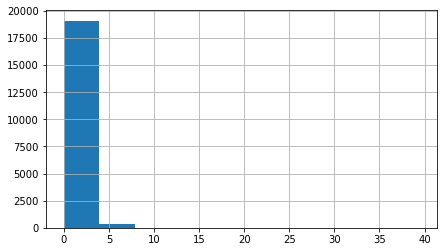

In [43]:
data[columns[33]].hist(figsize=(7,4))
plt.show();

<div style="border:solid gray 2px; padding: 20px">
Соотнешение содержания в руде золота и свинца не превышает в большинстве 4 к 1, но на графике заметны выбросы или аномалии
</div>    

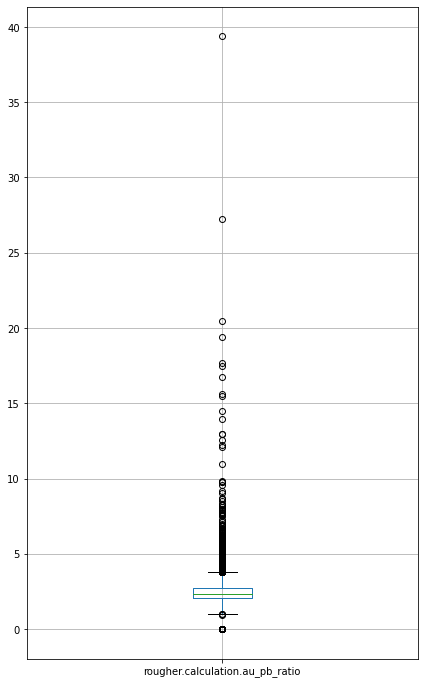

In [44]:
data.boxplot(column='rougher.calculation.au_pb_ratio', grid=True, figsize=(7, 12))
plt.show();

In [45]:
data['rougher.calculation.au_pb_ratio'].describe()

count    19439.000000
mean         2.420119
std          0.814935
min         -0.010548
25%          2.035434
50%          2.309665
75%          2.731794
max         39.379272
Name: rougher.calculation.au_pb_ratio, dtype: float64

In [46]:
data[data['rougher.calculation.au_pb_ratio'] > 5].count()

date                                          161
final.output.concentrate_ag                   161
final.output.concentrate_pb                   161
final.output.concentrate_sol                  161
final.output.concentrate_au                   161
                                             ... 
secondary_cleaner.state.floatbank5_a_level    161
secondary_cleaner.state.floatbank5_b_air      161
secondary_cleaner.state.floatbank5_b_level    161
secondary_cleaner.state.floatbank6_a_air      161
secondary_cleaner.state.floatbank6_a_level    161
Length: 87, dtype: int64

<div style="border:solid gray 2px; padding: 20px">
Необходимо избавиться от выбросов, удалим их.
</div>    

**Выходные концентраты**

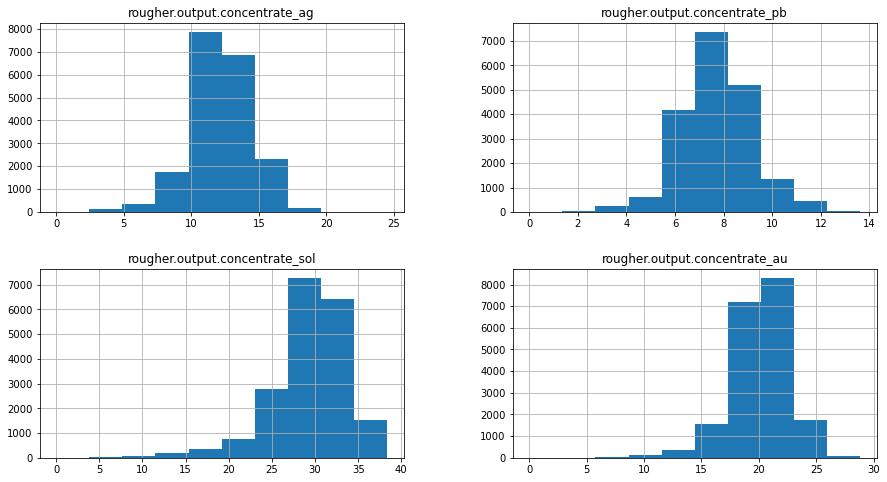

In [47]:
data[columns[[44,45,46,47]]].hist(figsize=(15,8))
plt.show();

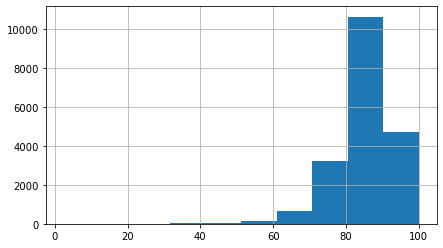

In [48]:
data[columns[48]].hist(figsize=(7,4))
plt.show();

<div style="border:solid gray 2px; padding: 20px">
Эти данные тоже имеют нормальное распределение.
</div>    

### Первый этап очистки

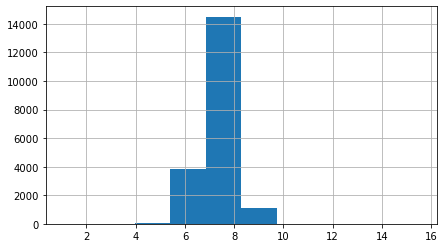

In [49]:
data['primary_cleaner.input.feed_size'].hist(figsize=(7,4))
plt.show();

<div style="border:solid gray 2px; padding: 20px">
Фракция руды для второго этапа 5-10
</div>    

**Реагенты**

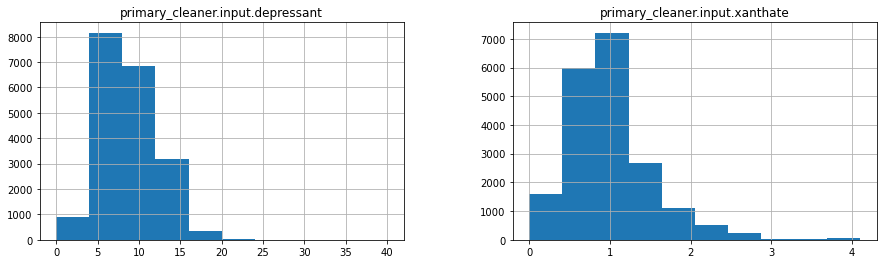

In [50]:
data[columns[[11,13]]].hist(figsize=(15,4))
plt.show();

<div style="border:solid gray 2px; padding: 20px">
Соотношение реагентов для очистки на первом этапе составляет 10:1
</div>    

**Очистка**

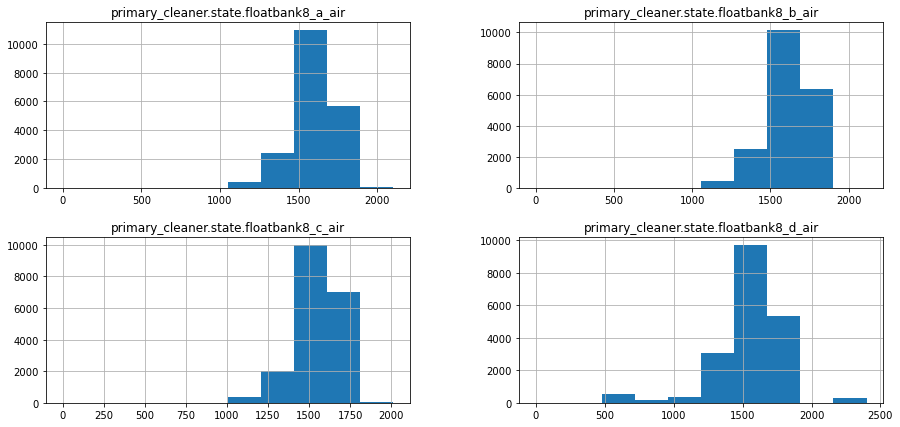

In [51]:
data[columns[[22,24,26,28]]].hist(figsize=(15,7))
plt.show();

<div style="border:solid gray 2px; padding: 20px">
Распределение данных более равномерно, чем на первом этапе. Заметна стабилизация процесса.
</div>    

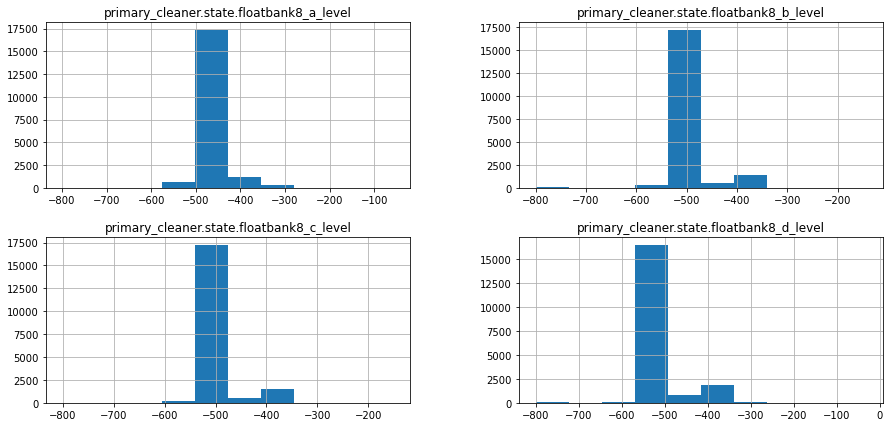

In [52]:
data[columns[[23,25,27,29]]].hist(figsize=(15,7))
plt.show();

<div style="border:solid gray 2px; padding: 20px">
Показатели флотации более стабильны, чем на первом этапе.
</div>    

**Хвосты**

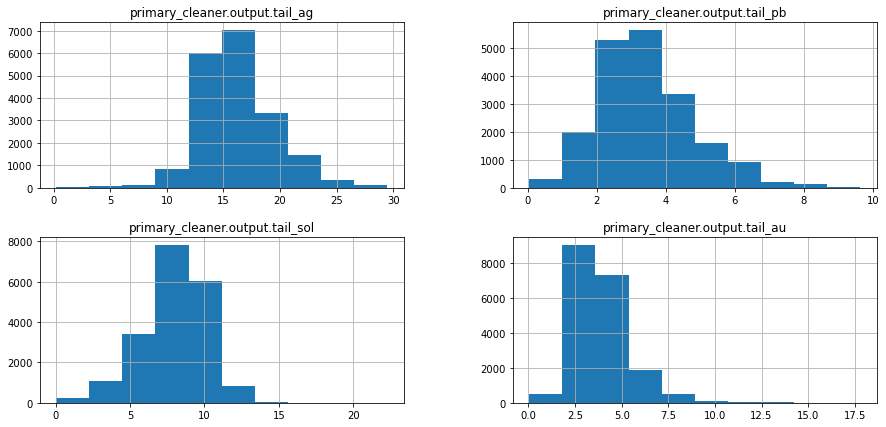

In [53]:
data[columns[[18,19,20,21]]].hist(figsize=(15,7))
plt.show();

**Выход руды**

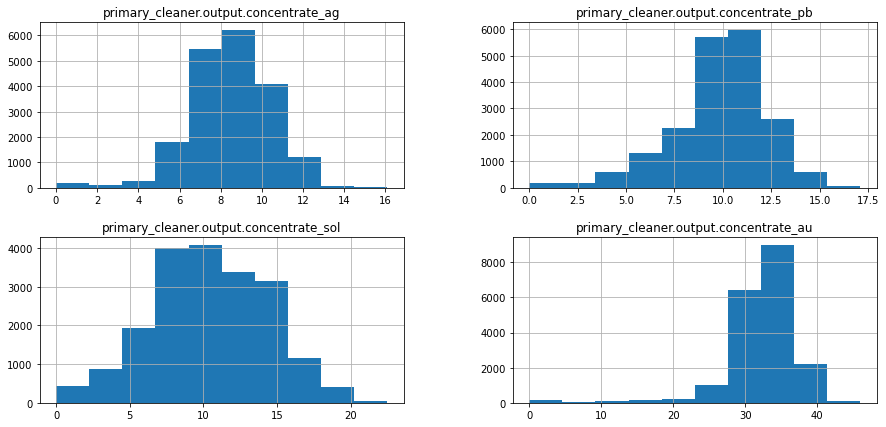

In [54]:
data[columns[[14,15,16,17]]].hist(figsize=(15,7))
plt.show();

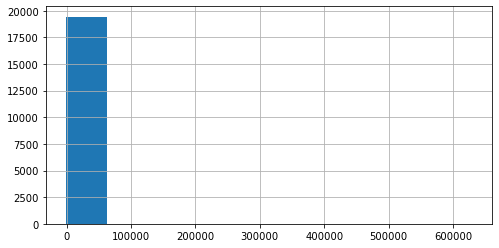

In [55]:
data[columns[31]].hist(figsize=(8,4))
plt.show();

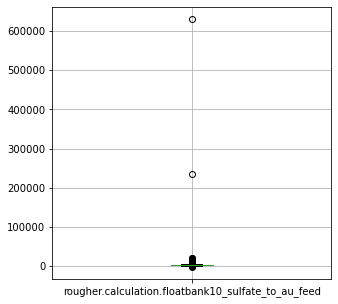

In [56]:
data.boxplot(column=columns[31], grid=True, figsize=(5, 5))
plt.show();

<div style="border:solid gray 2px; padding: 20px">
Замечены выбросы, необходимо удалить
</div>    

In [57]:
data[columns[31]].describe()

count     19439.000000
mean       3393.006244
std        4943.594439
min        -486.598675
25%        2611.430236
50%        3018.353876
75%        3676.758984
max      629638.977914
Name: rougher.calculation.floatbank10_sulfate_to_au_feed, dtype: float64

In [58]:
data[data[columns[31]] > 10000].count()

date                                          66
final.output.concentrate_ag                   66
final.output.concentrate_pb                   66
final.output.concentrate_sol                  66
final.output.concentrate_au                   66
                                              ..
secondary_cleaner.state.floatbank5_a_level    66
secondary_cleaner.state.floatbank5_b_air      66
secondary_cleaner.state.floatbank5_b_level    66
secondary_cleaner.state.floatbank6_a_air      66
secondary_cleaner.state.floatbank6_a_level    66
Length: 87, dtype: int64

### Второй этап очистки

**Очистка**

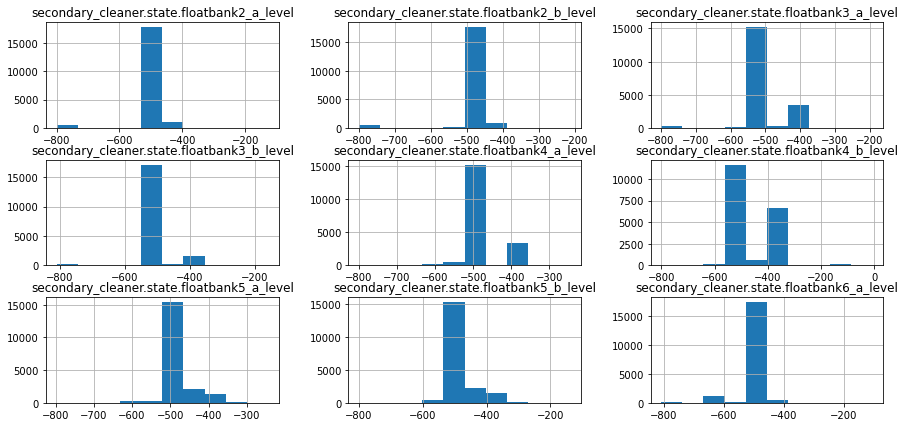

In [59]:
data[columns[[70,72,74,76,78,80,82,84,86]]].hist(figsize=(15,7))
plt.show();

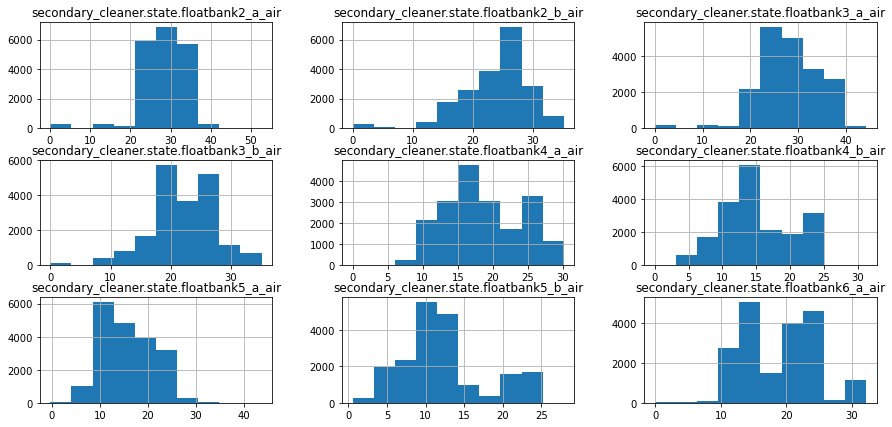

In [60]:
data[columns[[69,71,73,75,77,79,81,83,85]]].hist(figsize=(15,7))
plt.show();

**Хвосты**

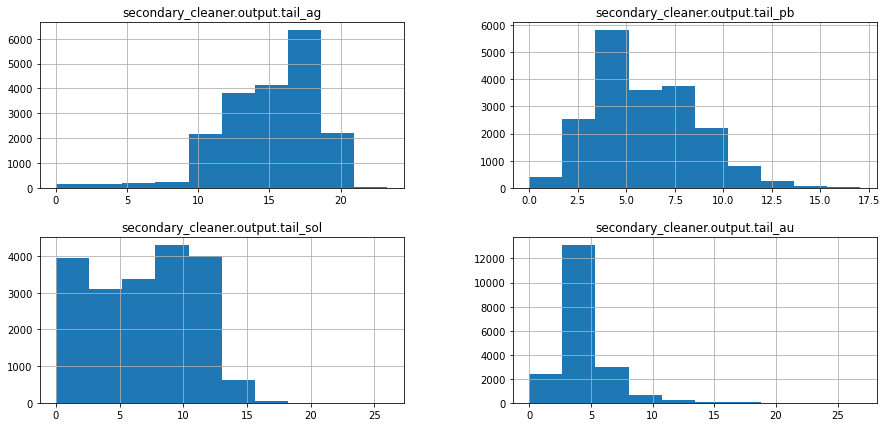

In [61]:
data[columns[[65,66,67,68]]].hist(figsize=(15,7))
plt.show();

### Финальный концентрат

In [62]:
final_columns = columns[0:10]

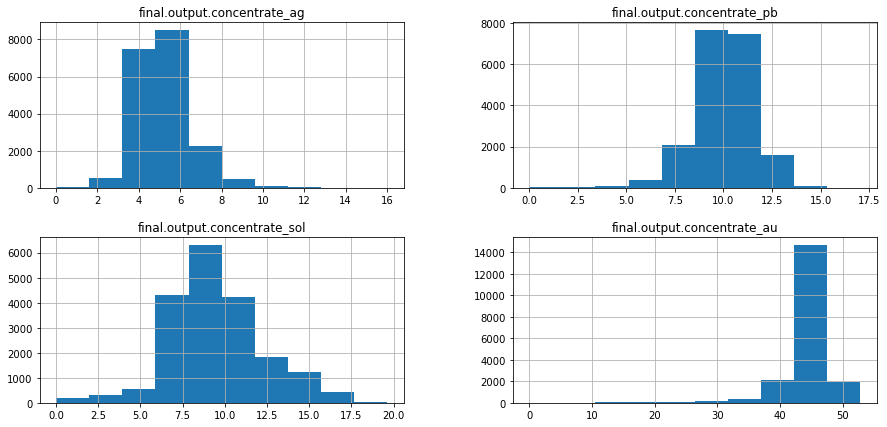

In [63]:
data[columns[[1,2,3,4]]].hist(figsize=(15,7))
plt.show();

**Хвосты**

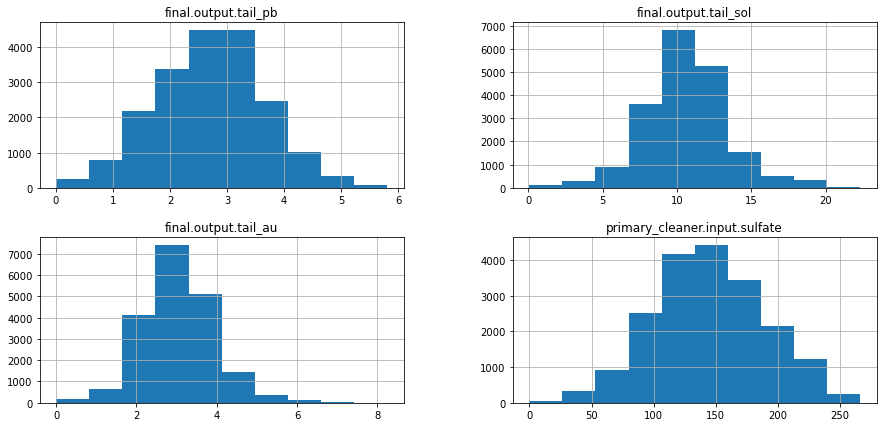

In [64]:
data[columns[[7,8,9,10]]].hist(figsize=(15,7))
plt.show();

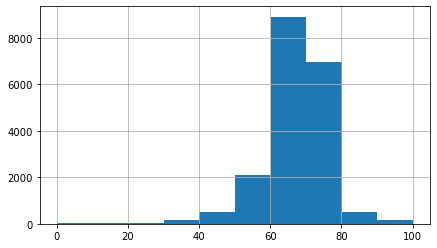

In [65]:
data['final.output.recovery'].hist(figsize=(7,4))
plt.show();

<div style="border:solid gray 2px; padding: 20px">
Эффективность восстановления составляет от 60 до 80%
</div>    

<div style="border:solid gray 2px; padding: 20px">
По большей части мы видим нормальное распределение признаков.</div>

### Общий анализ 

**Посмотрим как меняется концентрация металлов на разных этапах очистки**

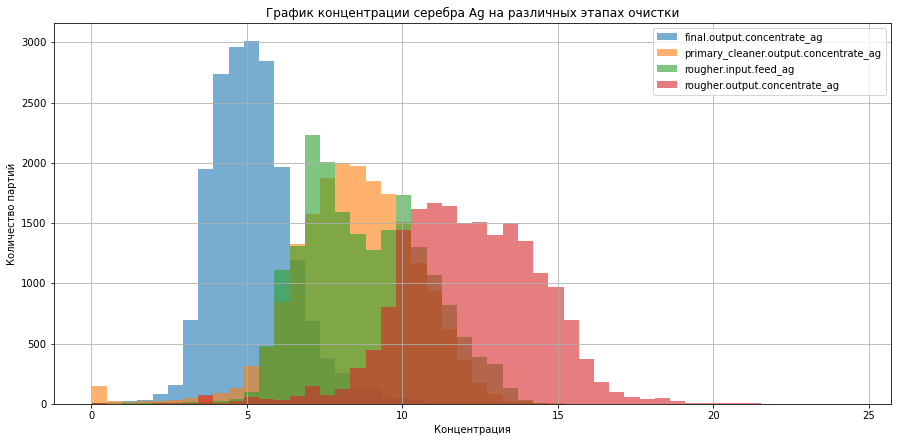

In [66]:
data[columns[[1,14,34,44]]].plot(kind='hist', 
                                      figsize=(15,7), 
                                      alpha=0.6, 
                                      bins=50,
                                      grid=True)
plt.title('График концентрации серебра Ag на различных этапах очистки')
plt.xlabel('Концентрация')
plt.ylabel('Количество партий')
plt.show();

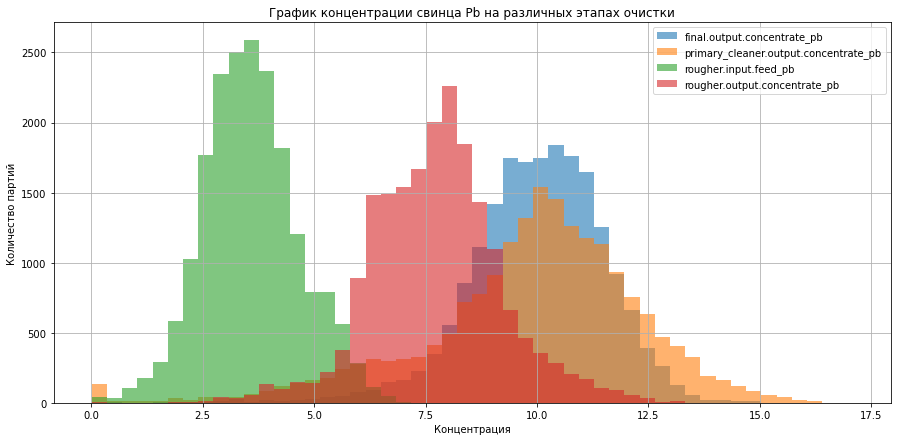

In [67]:
data[columns[[2,15,35,45]]].plot(kind='hist', 
                                      figsize=(15,7), 
                                      alpha=0.6, 
                                      bins=50,
                                      grid=True)
plt.title('График концентрации свинца Pb на различных этапах очистки')
plt.xlabel('Концентрация')
plt.ylabel('Количество партий')
plt.show();

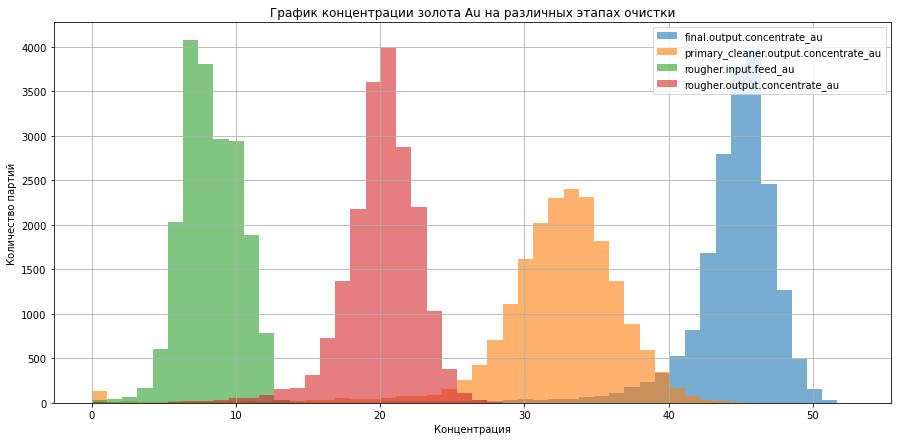

In [68]:
data[columns[[4,17,39,47]]].plot(kind='hist', 
                                      figsize=(15,7), 
                                      alpha=0.6, 
                                      bins=50,
                                      grid=True)
plt.title('График концентрации золота Au на различных этапах очистки')
plt.xlabel('Концентрация')
plt.ylabel('Количество партий')
plt.show();

<div style="border:solid gray 2px; padding: 20px">
На графиках видно, что концентрация золота в руде увеличивается на каждом этапе очистки, концентрация серебра наоборот снижается, а вот концентрация свинца изменяется незначительно.</div>

**Сравним распределения размеров гранул сырья на обучающей и тестовой выборках.**

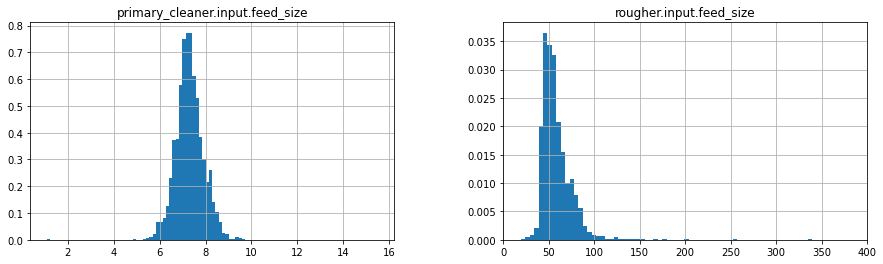

In [69]:
data[['primary_cleaner.input.feed_size', 'rougher.input.feed_size']].hist(figsize=(15,4), density=True, bins=100)
plt.xlim(0,400)
plt.show();

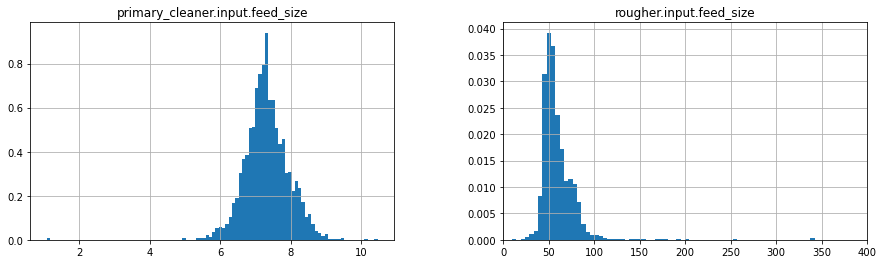

In [70]:
data_train[['primary_cleaner.input.feed_size', 'rougher.input.feed_size']].hist(figsize=(15,4), density=True, bins=100)
plt.xlim(0,400)
plt.show();

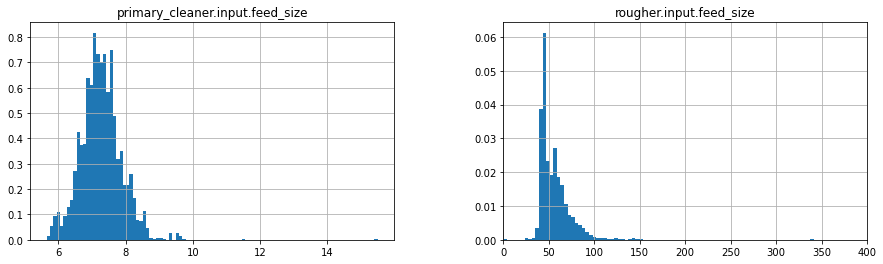

In [71]:
data_test[['primary_cleaner.input.feed_size', 'rougher.input.feed_size']].hist(figsize=(15,4), density=True, bins=100)
plt.xlim(0,400)
plt.show();

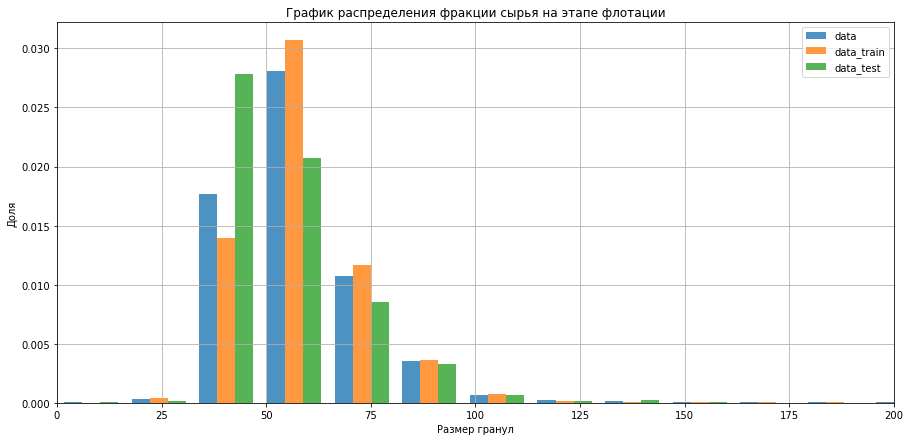

In [72]:
x1 = data['rougher.input.feed_size']
x2 = data_train['rougher.input.feed_size']
x3 = data_test['rougher.input.feed_size']
plt.figure(figsize=(15,7))
plt.grid(b=True)
plt.hist([x1, x2, x3], density=True, bins=30, alpha=0.8, label=['data', 'data_train', 'data_test'])
plt.xlim(0,200)
plt.title('График распределения фракции сырья на этапе флотации')
plt.xlabel('Размер гранул')
plt.ylabel('Доля')
plt.legend();
plt.show();

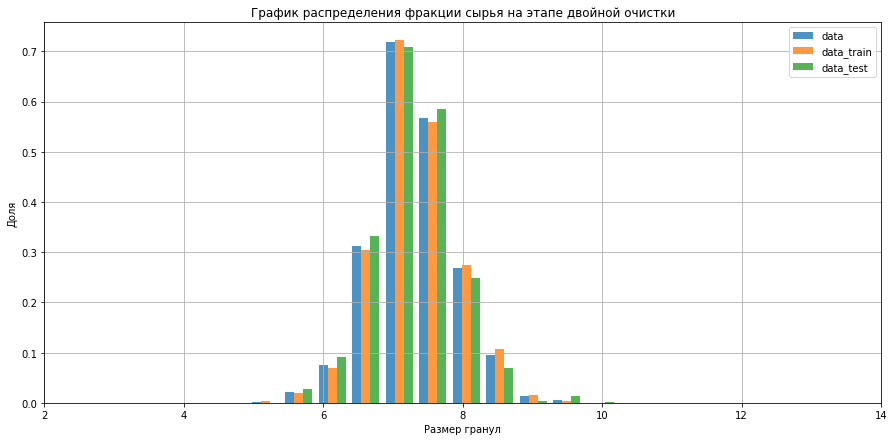

In [73]:
x1 = data['primary_cleaner.input.feed_size']
x2 = data_train['primary_cleaner.input.feed_size']
x3 = data_test['primary_cleaner.input.feed_size']
plt.figure(figsize=(15,7))
plt.grid(b=True)
plt.hist([x1, x2, x3], density=True, bins=30, alpha=0.8, label=['data', 'data_train', 'data_test'])
plt.xlim(2,14)
plt.title('График распределения фракции сырья на этапе двойной очистки')
plt.xlabel('Размер гранул')
plt.ylabel('Доля')
plt.legend();
plt.show();

<div style="border:solid gray 2px; padding: 20px">
На графиках видно, что распределение гранул сырья в выборках и генеральной совокупности совпадают по значениям и распределению.</div>

**Исследуем суммарную концентрацию всех веществ на разных стадиях**

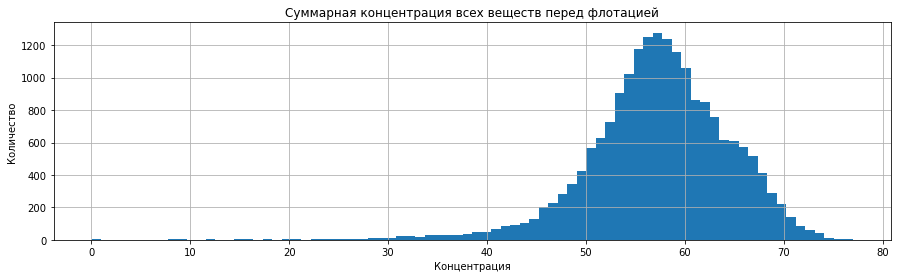

In [74]:
(
    data['rougher.input.feed_ag'] + \
    data['rougher.input.feed_pb'] + \
    data['rougher.input.feed_sol'] + \
    data['rougher.input.feed_au']
).hist(figsize=(15,4), bins=80)
plt.title('Суммарная концентрация всех веществ перед флотацией')
plt.xlabel('Концентрация')
plt.ylabel('Количество')
plt.show();

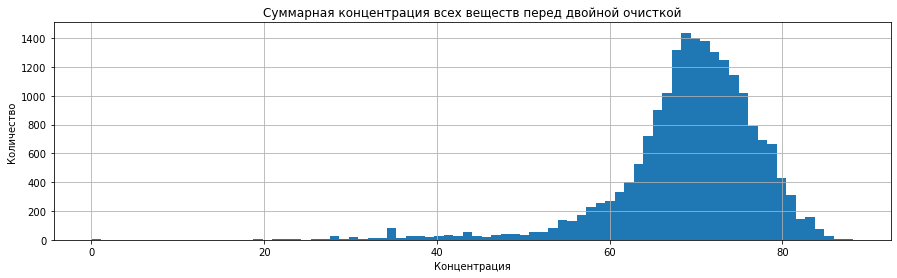

In [75]:
(
    data['rougher.output.concentrate_ag'] + \
    data['rougher.output.concentrate_pb'] + \
    data['rougher.output.concentrate_sol'] + \
    data['rougher.output.concentrate_au']
).hist(figsize=(15,4), bins=80)
plt.title('Суммарная концентрация всех веществ перед двойной очисткой')
plt.xlabel('Концентрация')
plt.ylabel('Количество')
plt.show();

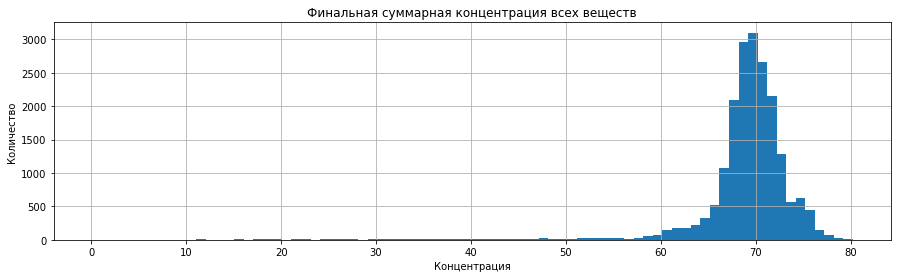

In [76]:
(
    data['final.output.concentrate_ag'] + \
    data['final.output.concentrate_pb'] + \
    data['final.output.concentrate_sol'] + \
    data['final.output.concentrate_au']
).hist(figsize=(15,4), bins=80)
plt.title('Финальная суммарная концентрация всех веществ')
plt.xlabel('Концентрация')
plt.ylabel('Количество')
plt.show();

<div style="border:solid gray 2px; padding: 20px">
Суммарная концентрация веществ до начала обработки находилась в диапазоне от 45 до 70. После 65-75. Концентрация увеличилась.</div>

**Необходимо избавиться от аномалий, они сильно ухудшат качество модели**

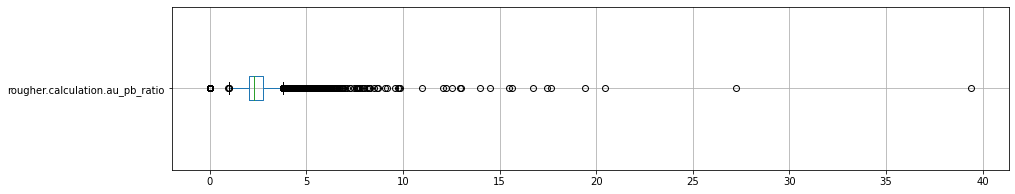

In [77]:
data.boxplot(column='rougher.calculation.au_pb_ratio', grid=True, figsize=(15, 3), vert=False)
plt.show();

In [78]:
data[data['rougher.calculation.au_pb_ratio'] > 5].count()

date                                          161
final.output.concentrate_ag                   161
final.output.concentrate_pb                   161
final.output.concentrate_sol                  161
final.output.concentrate_au                   161
                                             ... 
secondary_cleaner.state.floatbank5_a_level    161
secondary_cleaner.state.floatbank5_b_air      161
secondary_cleaner.state.floatbank5_b_level    161
secondary_cleaner.state.floatbank6_a_air      161
secondary_cleaner.state.floatbank6_a_level    161
Length: 87, dtype: int64

In [79]:
df1 = data[data['rougher.calculation.au_pb_ratio'] > 5]
data = data.set_index('date')
df1 = df1.set_index('date')

In [80]:
data = data[~data.index.isin(df1.index)]

**Необходимо посмотреть на остальные столбцы и удалить аномалии**

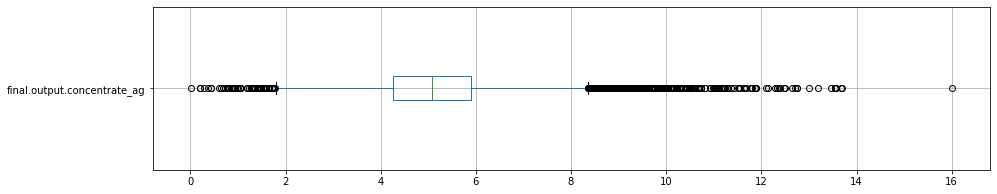

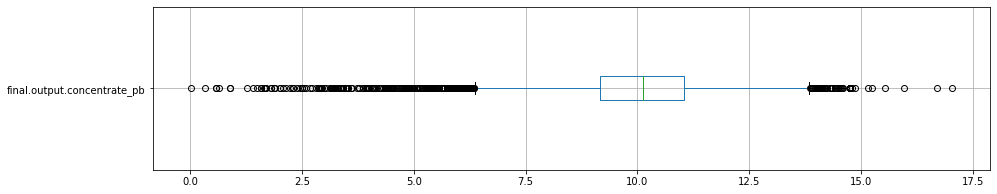

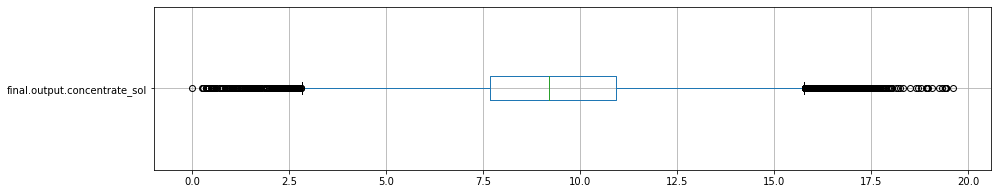

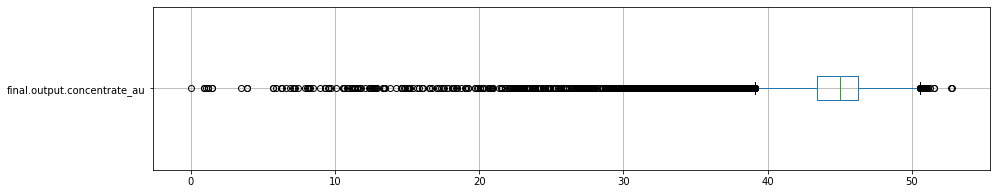

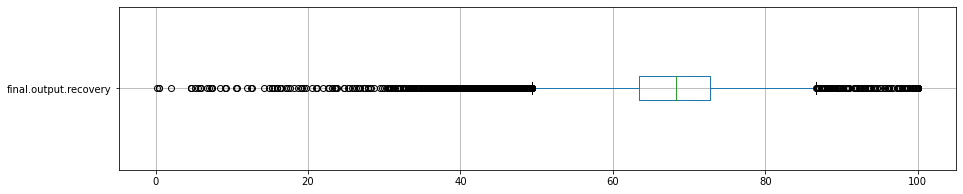

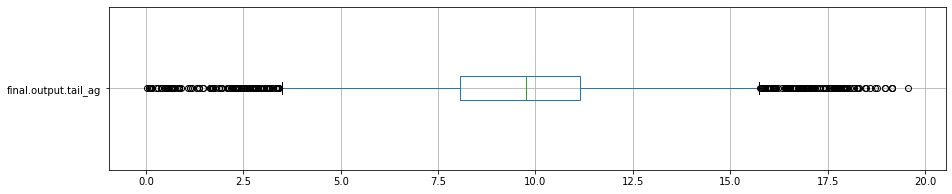

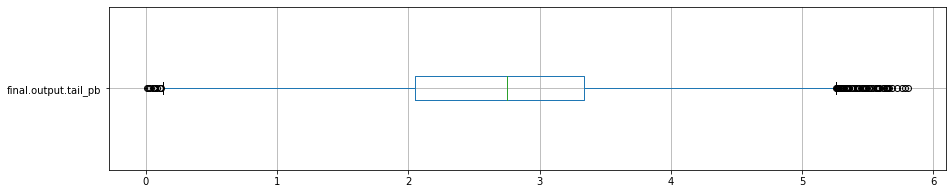

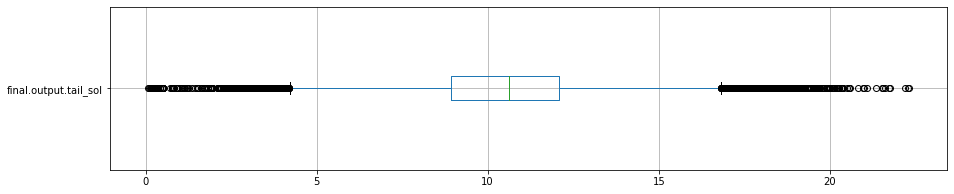

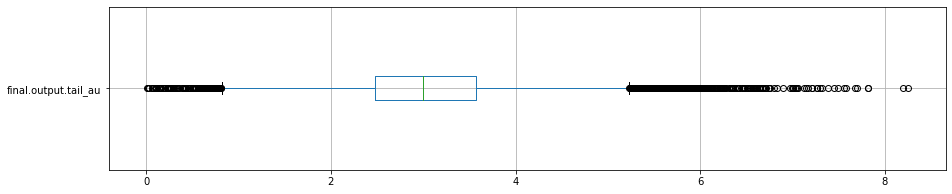

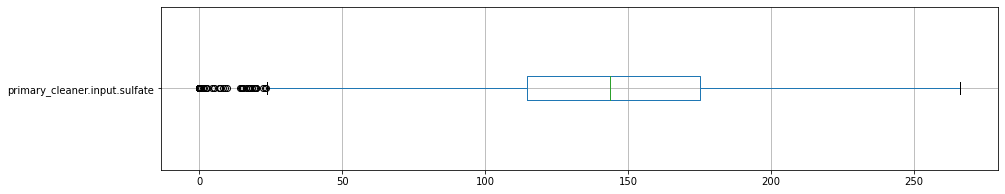

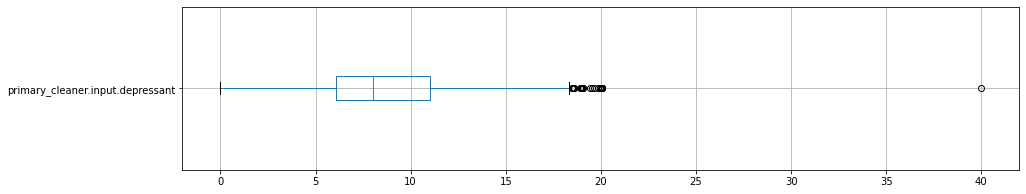

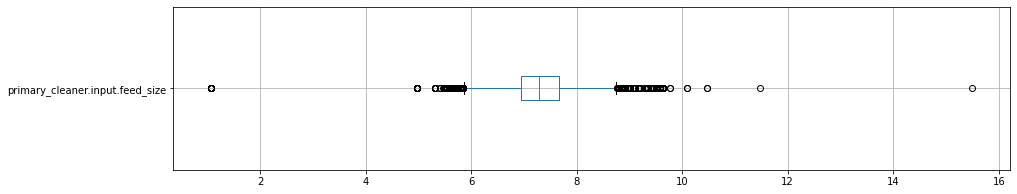

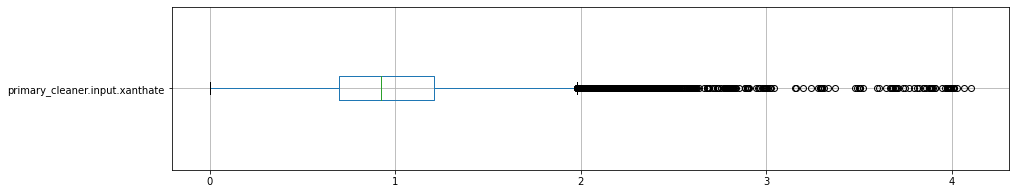

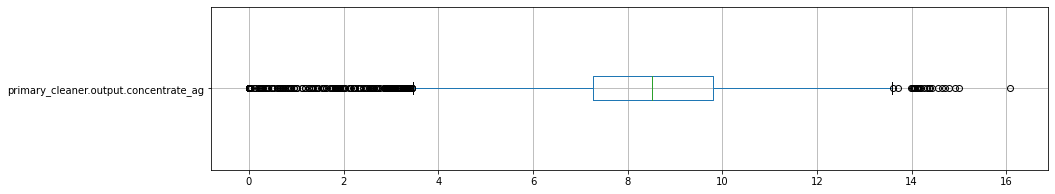

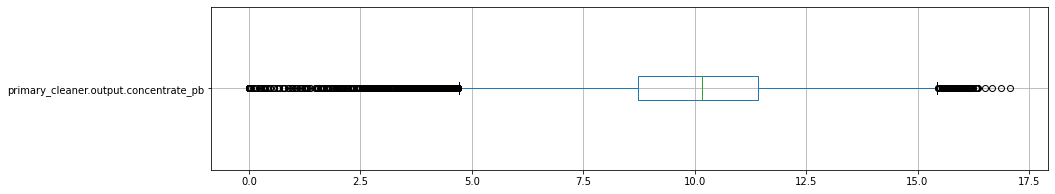

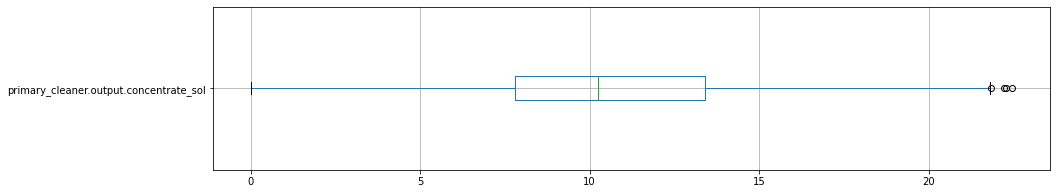

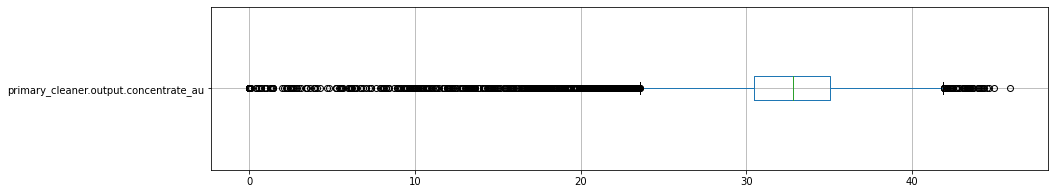

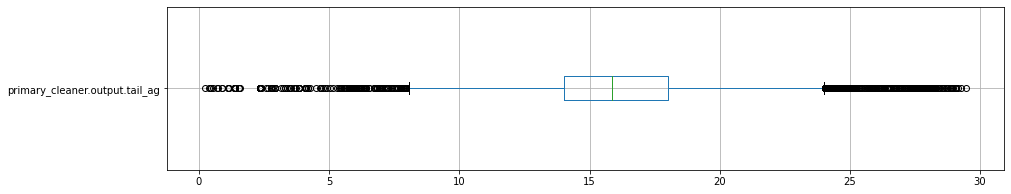

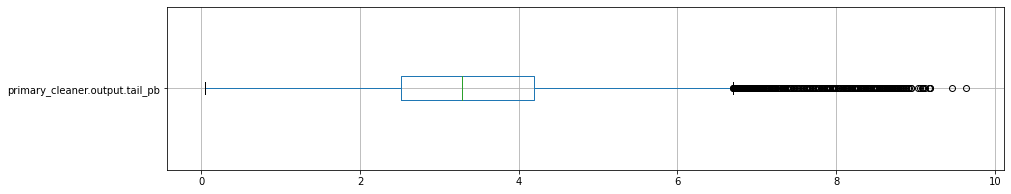

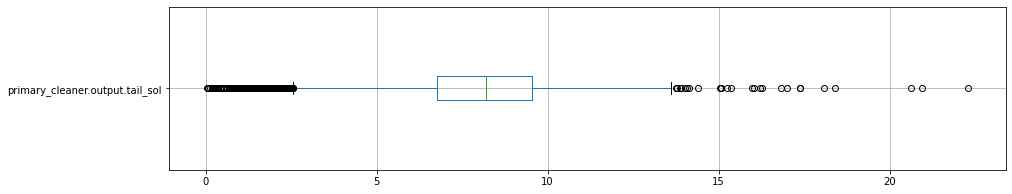

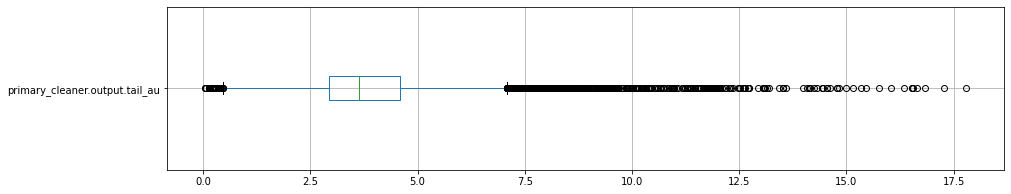

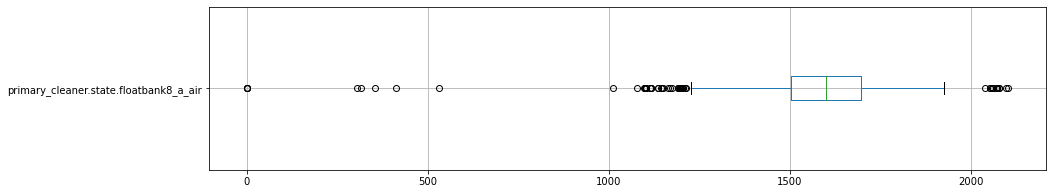

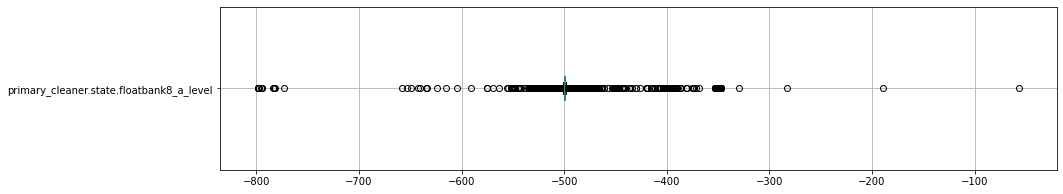

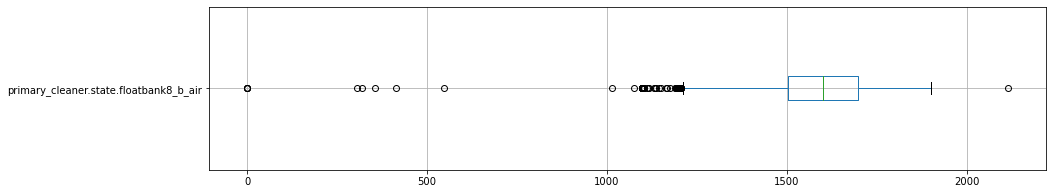

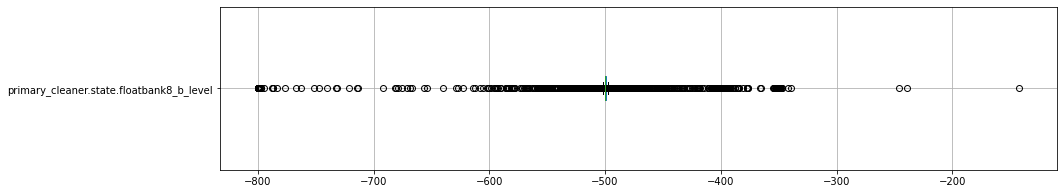

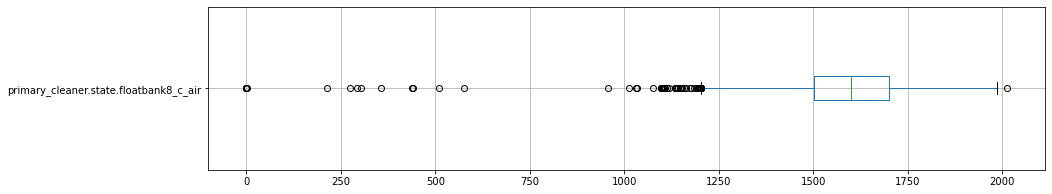

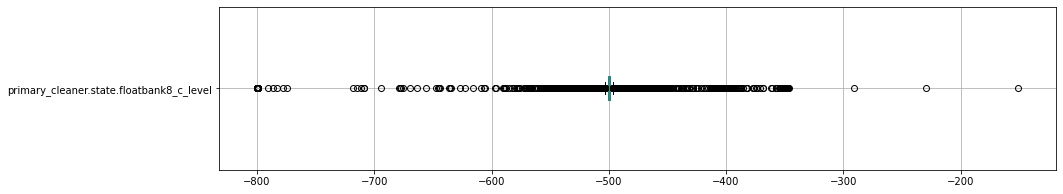

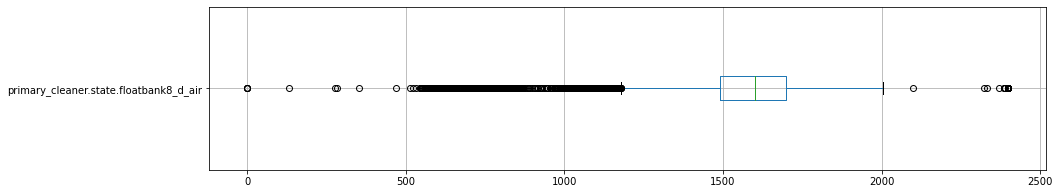

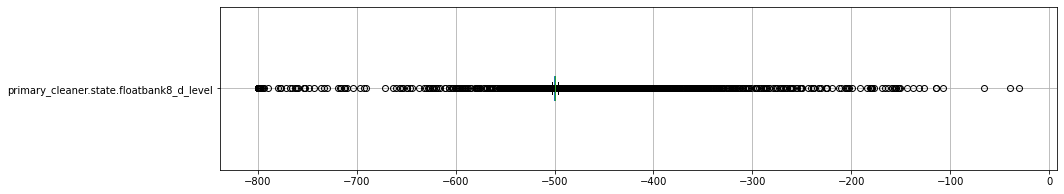

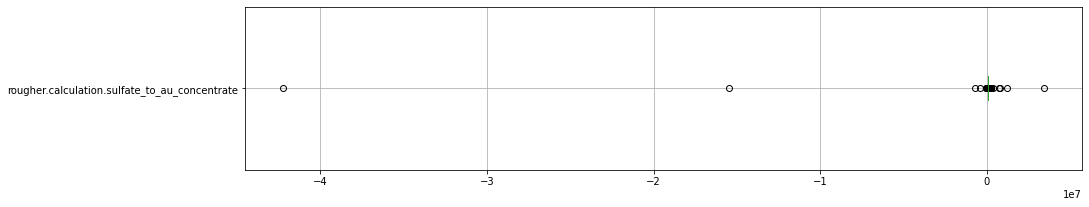

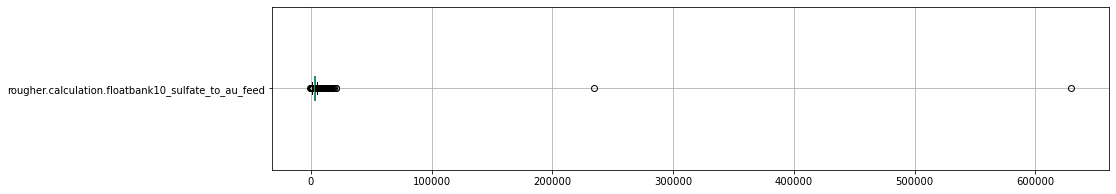

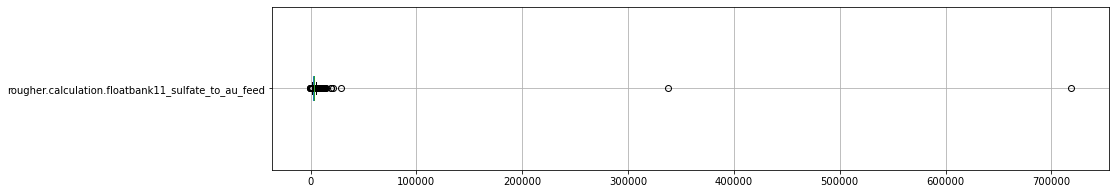

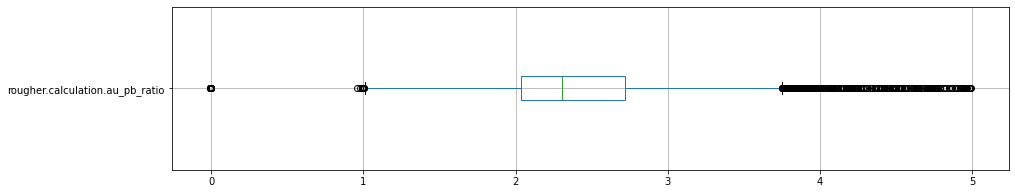

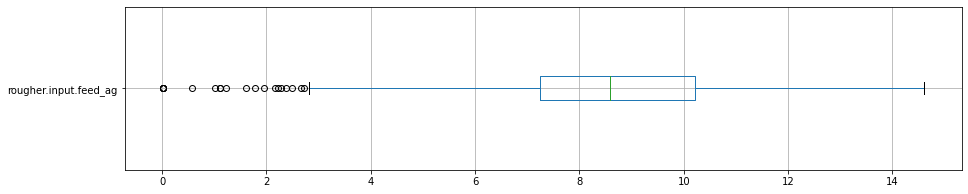

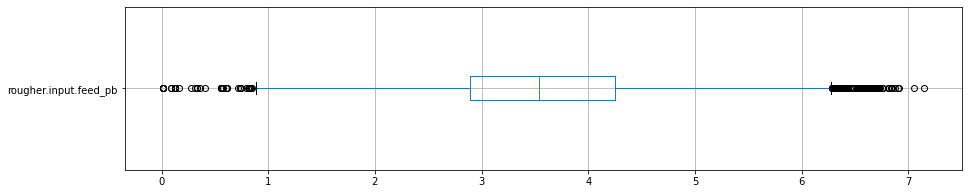

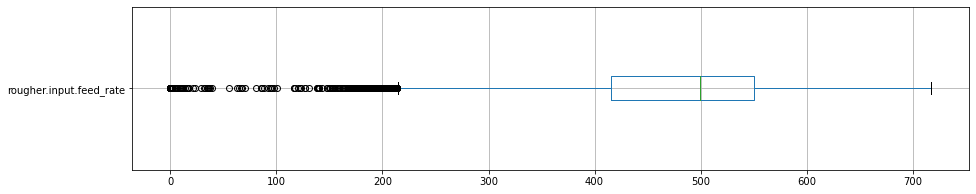

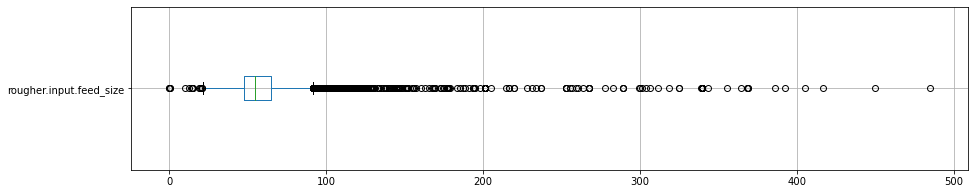

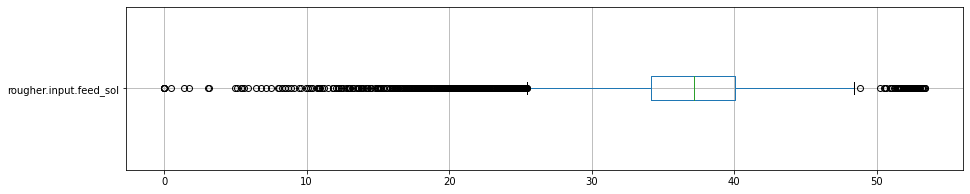

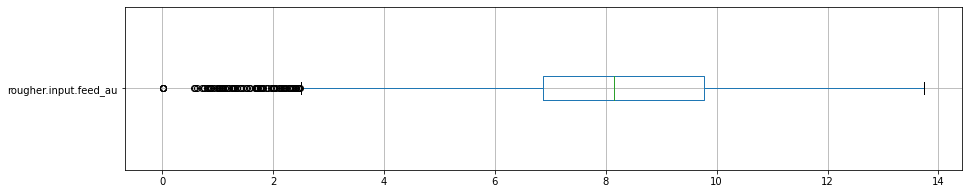

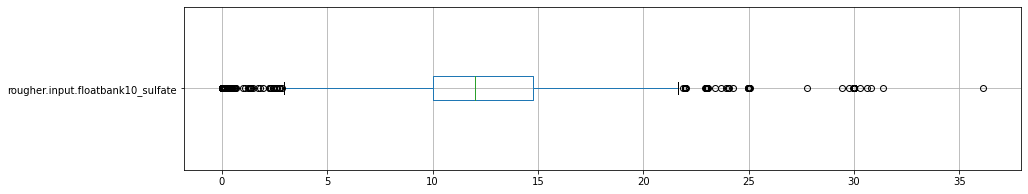

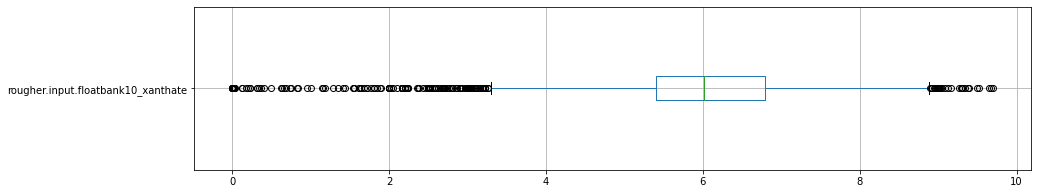

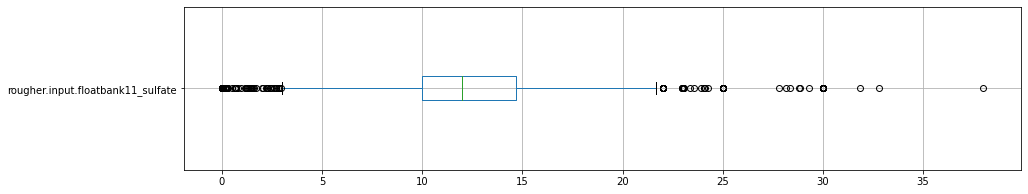

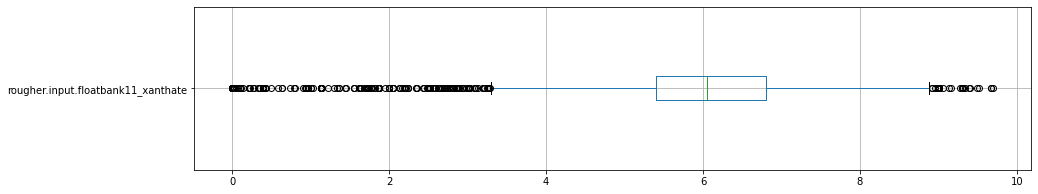

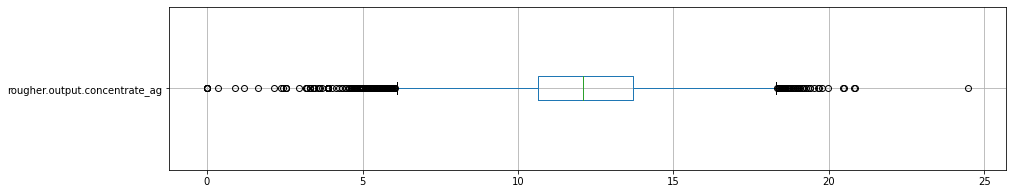

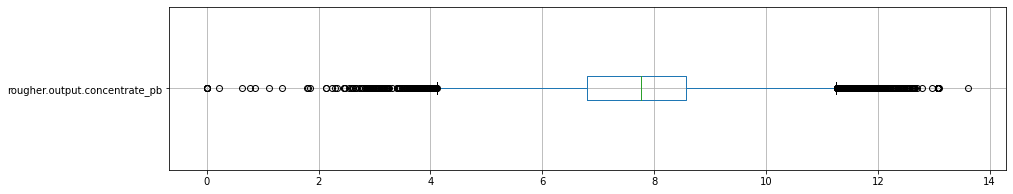

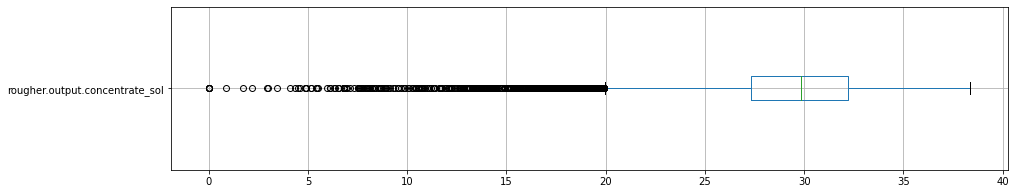

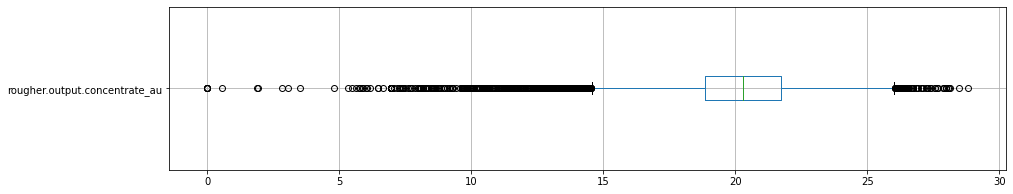

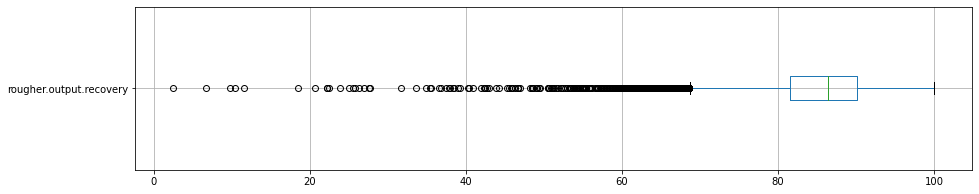

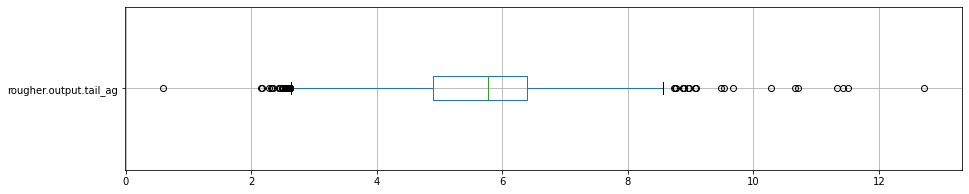

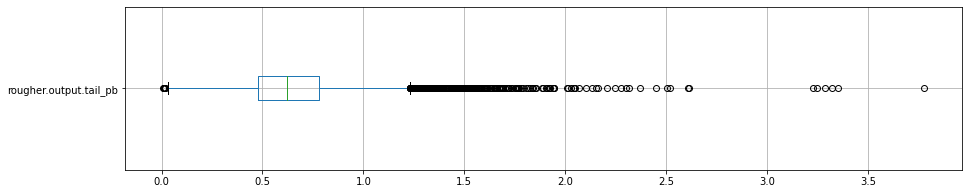

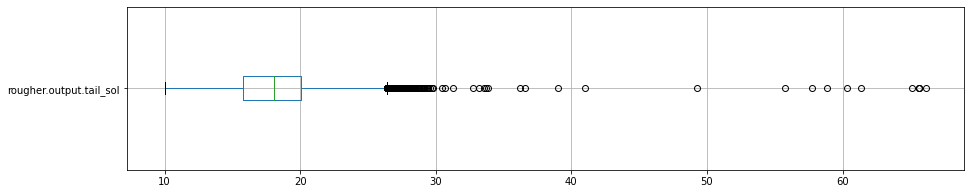

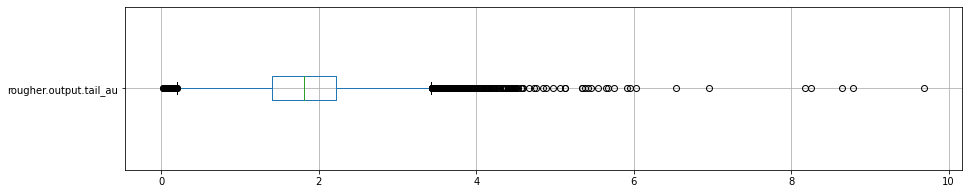

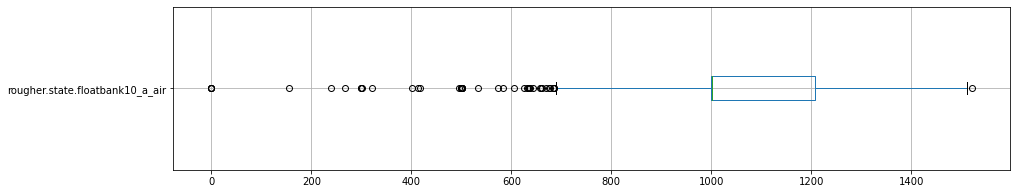

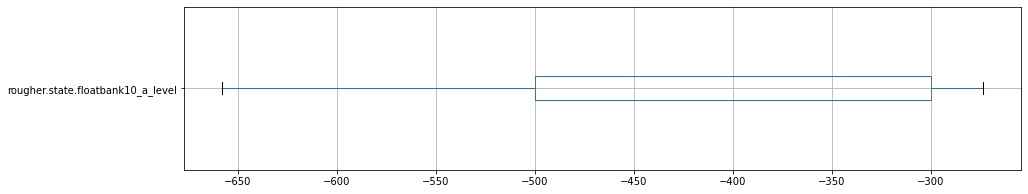

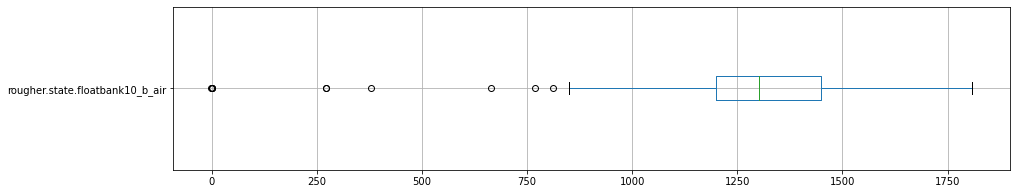

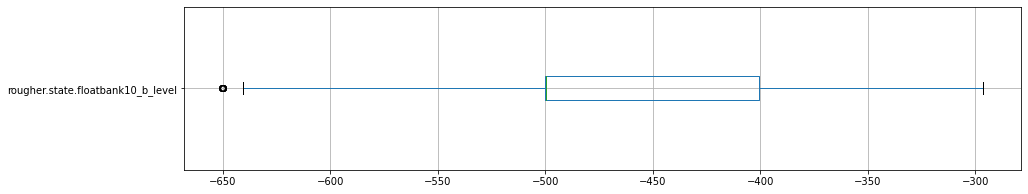

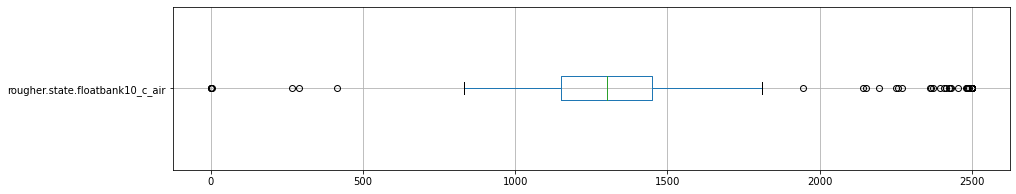

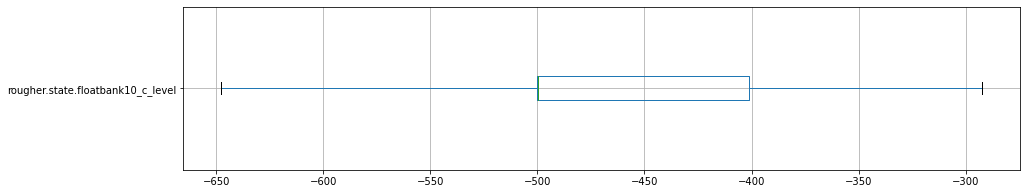

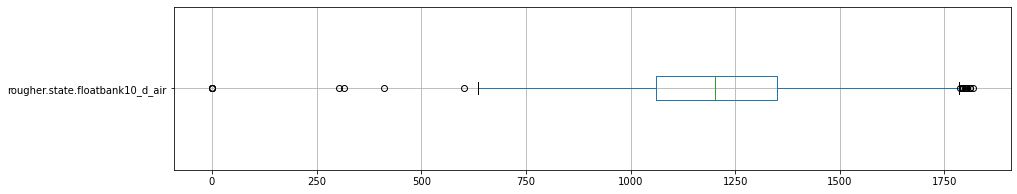

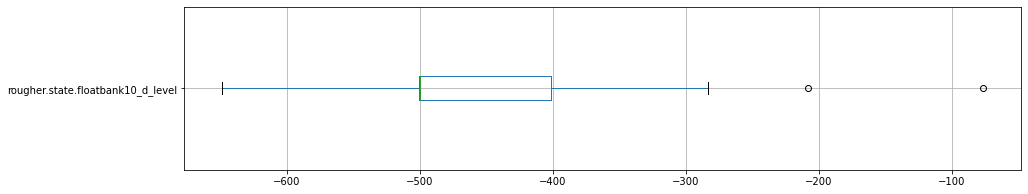

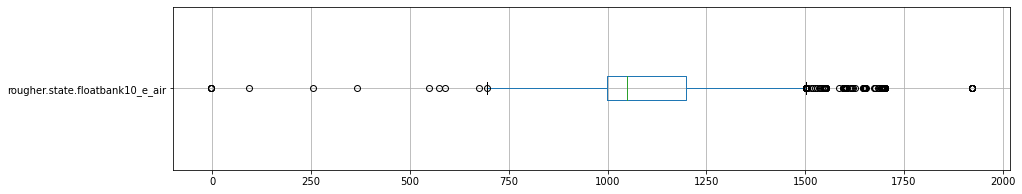

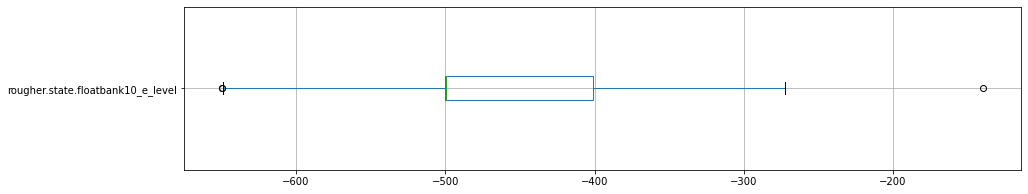

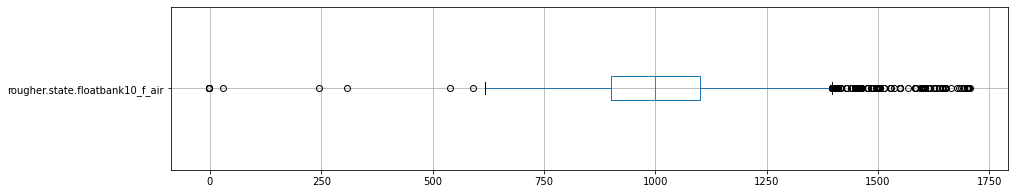

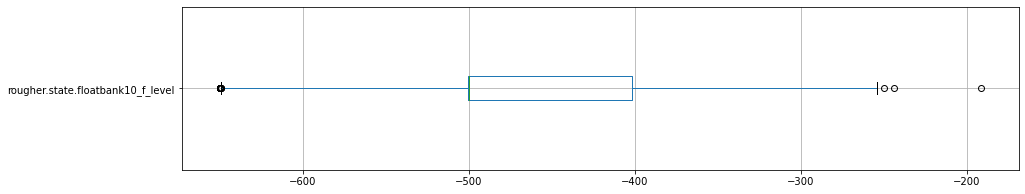

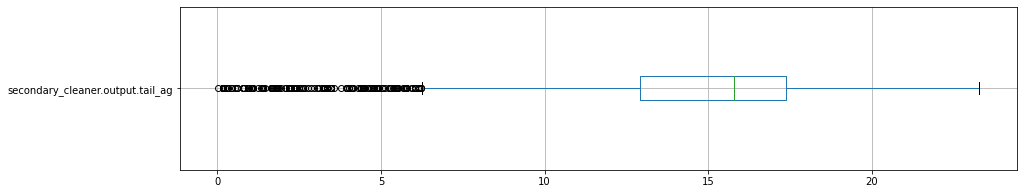

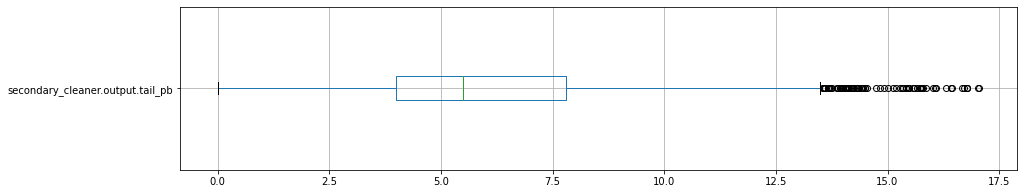

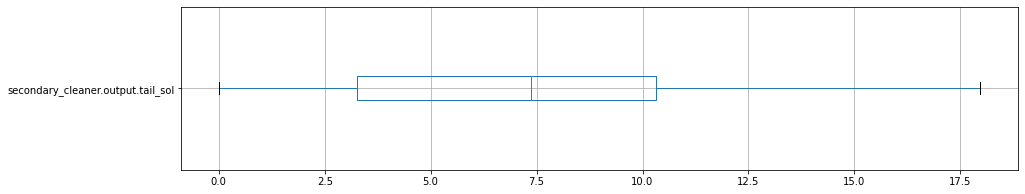

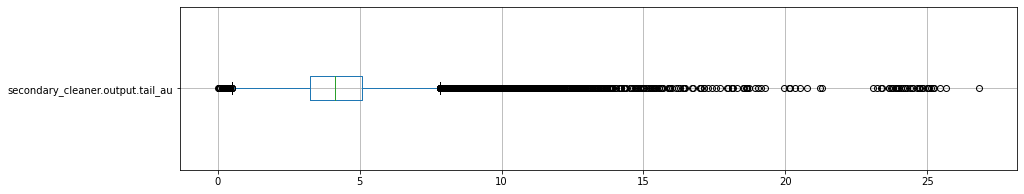

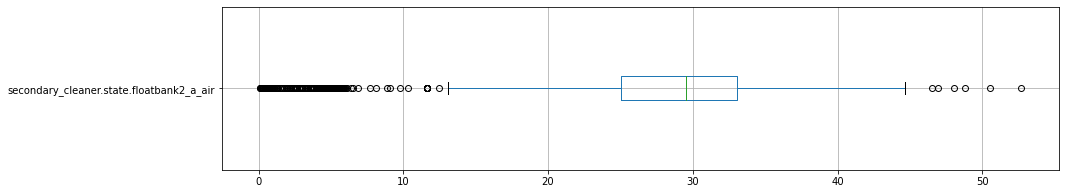

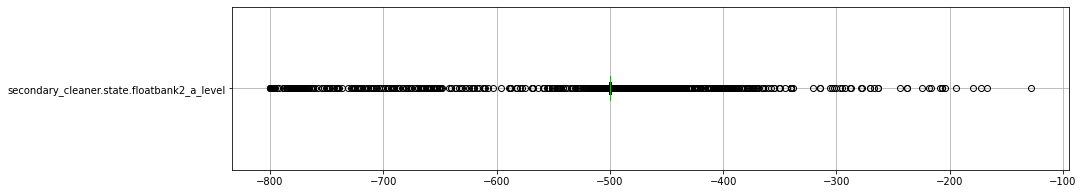

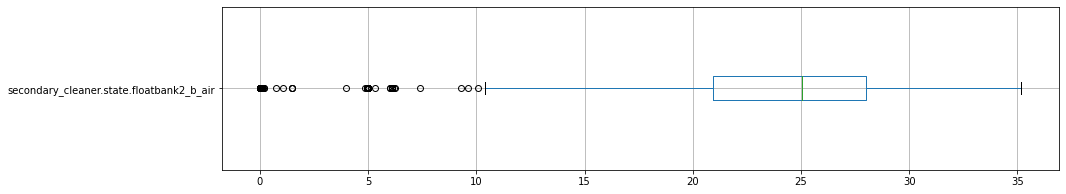

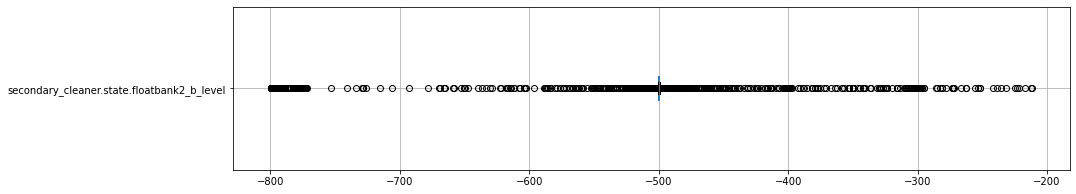

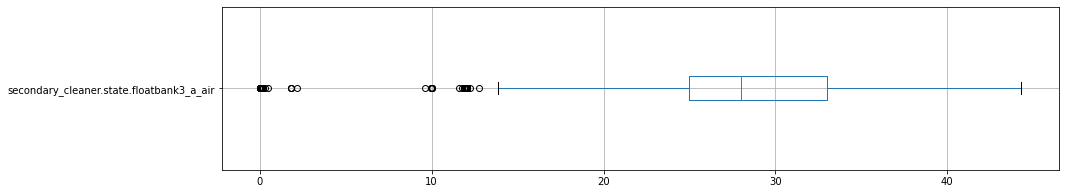

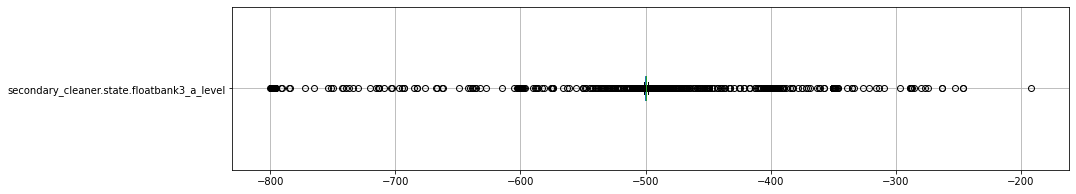

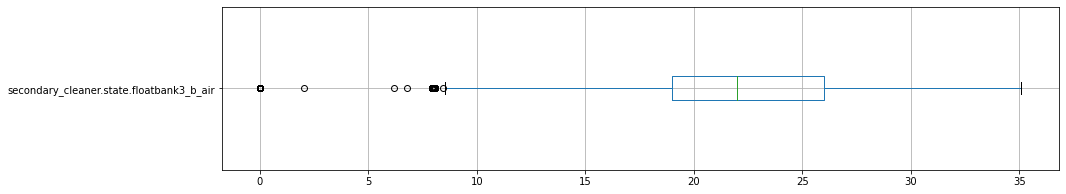

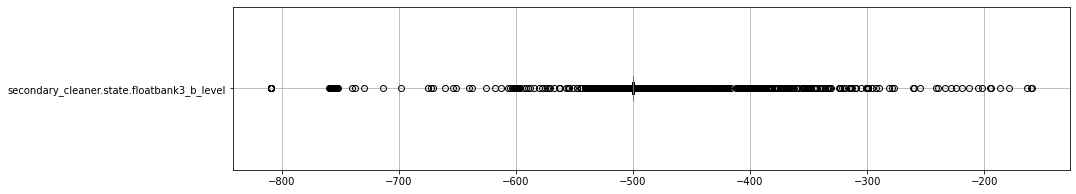

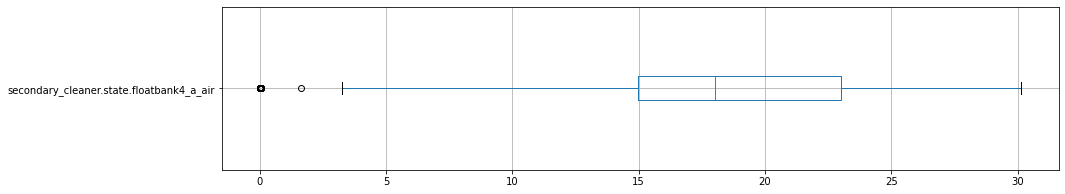

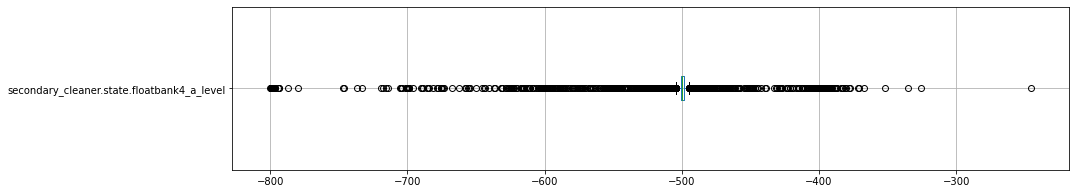

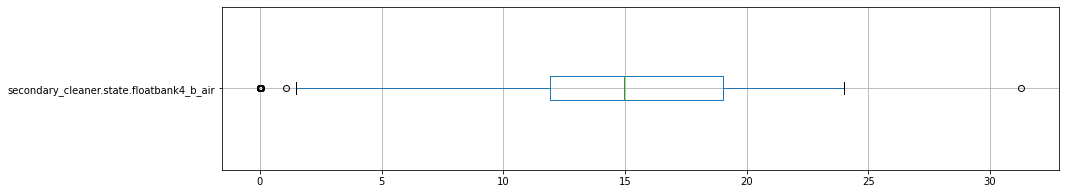

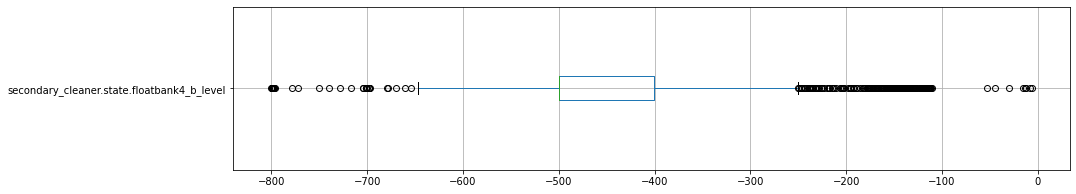

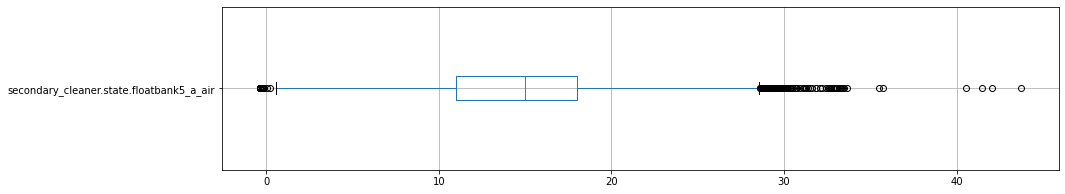

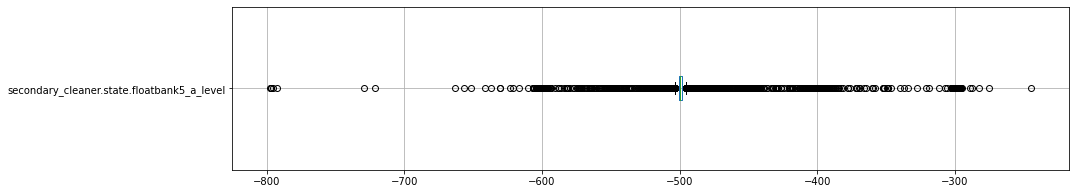

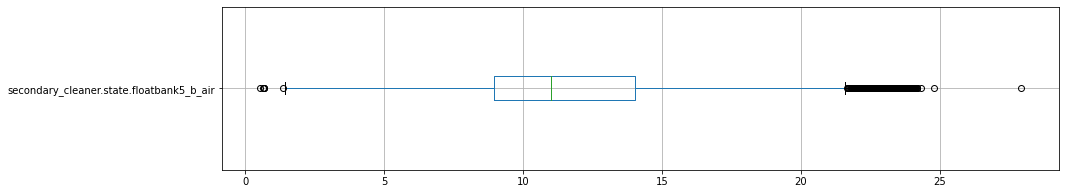

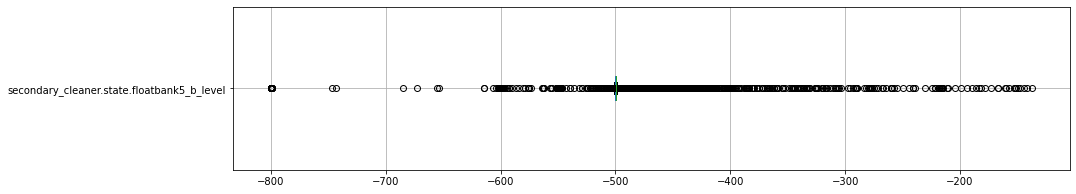

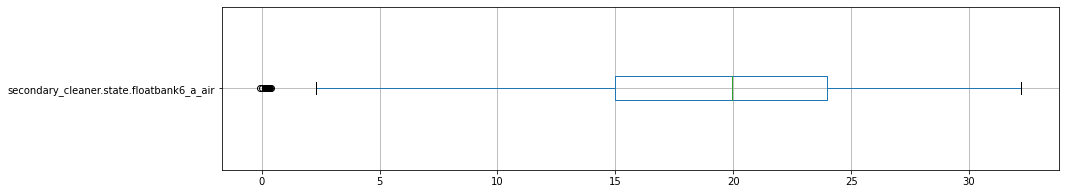

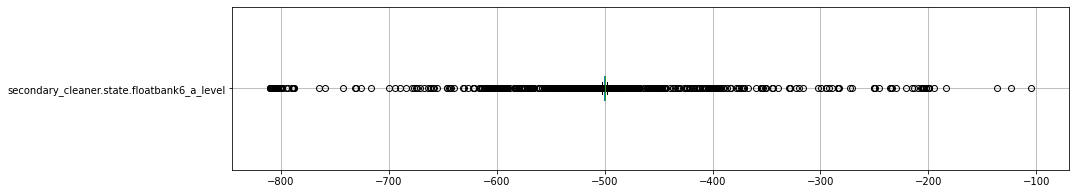

In [81]:
for i in range(0,86):
    data.boxplot(column=data.columns[i], grid=True, figsize=(15, 3), vert=False)
    plt.show();

<div style="border:solid gray 2px; padding: 20px">
Удалять данные за границами квартилей и по правилу трех сигм не будем, так как во первых такие данные превышают 10% от общего количества, во вторых они могут быть не ошибочными в виду неоднородности руды как по концентрации веществ, так и по фракционности,  непостоянное и неоптимальное физико-химическое состояние флотационной пульпы (смеси твёрдых частиц и жидкости). По графику с усами выборочно удалим только самые выбивающиеся из распределения данные.</div>

In [82]:
df2 = data[data['primary_cleaner.input.depressant'] > 21]
data = data[~data.index.isin(df2.index)]

In [83]:
df3 = data[data['rougher.calculation.floatbank10_sulfate_to_au_feed'] > 10000]
data = data[~data.index.isin(df3.index)]

In [84]:
df4 = data[data['rougher.calculation.floatbank11_sulfate_to_au_feed'] > 10000]
data = data[~data.index.isin(df4.index)]

### Синхронизация выброк

In [85]:
data = data.reset_index()

In [86]:
data_train = pd.merge(data, data_train['date'], how='inner', on=['date'])

In [87]:
drop_columns = not_data_test_columns
drop_columns.remove('rougher.output.recovery')
drop_columns.remove('final.output.recovery')

In [88]:
data_test = pd.merge(data, data_test['date'], how='inner', on=['date'])
data_test = data_test.drop(drop_columns, axis=1)

In [89]:
data_train.shape

(13964, 87)

In [90]:
data_test.shape

(5217, 55)

In [91]:
print('Размер тренировочной выборки:', (len(data_train) / len(data)) * 100, '%')
print('Размер тестовой выборки:', (len(data_test) / len(data)) * 100, '%')

Размер тренировочной выборки: 72.80120953026432 %
Размер тестовой выборки: 27.198790469735677 %


**Сравним еще раз данные фракции руды между тренировной и тестовой выборками**

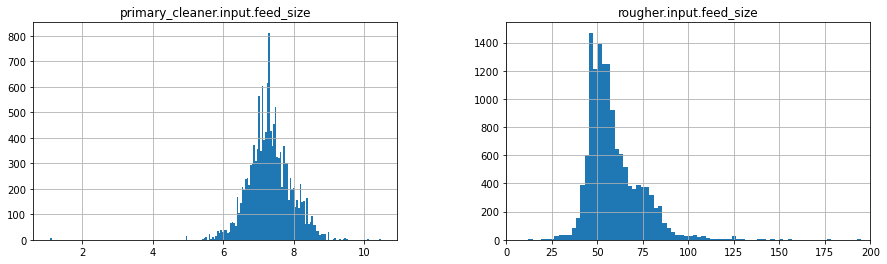

In [92]:
data_train[['primary_cleaner.input.feed_size', 'rougher.input.feed_size']].hist(figsize=(15,4), bins=200)
plt.xlim(0, 200)
plt.show();

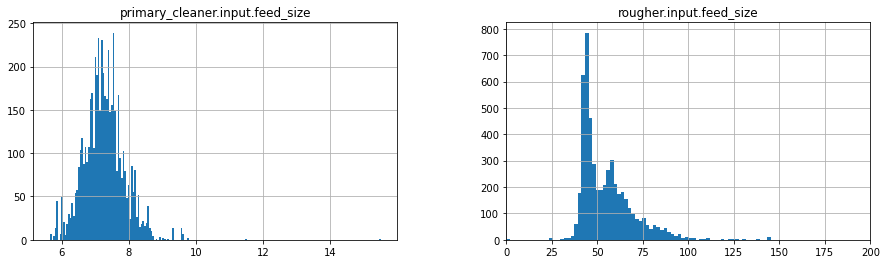

In [93]:
data_test[['primary_cleaner.input.feed_size', 'rougher.input.feed_size']].hist(figsize=(15,4), bins=200)
plt.xlim(0, 200)
plt.show();

<div style="border:solid gray 2px; padding: 20px">
Распределение исследуемых данных имеет нормальное распределение и совпадает по значению на всех этапах очистки. Данные готовы для обучения моделей</div>

## Модель

### Функция для вычисления итоговой sMAPE

<img src=https://pictures.s3.yandex.net/resources/smape_1576239058.jpg width=600 height=500>

<img src=https://pictures.s3.yandex.net/resources/_smape_1576239054.jpg width=600 height=500>

In [94]:
def smape(target_test, predict):
    N = len(target_test)
    smape = 1/N * np.sum((abs(target_test - predict) / ((abs(target_test) + abs(predict)) / 2)) * 100)
    return smape

In [95]:
def final_smape(smape_rougher, smape_cleaner):
    final_smape = 0.25 * smape_rougher + 0.75 * smape_cleaner
    return final_smape

### Признаки для модели на этапе флотации

In [96]:
# столбцы для тренировочной выборки этапа флотации
train_rougher_columns = data_test.columns[[14,15,16,17,18,19,20,21,22,23,25,26,27,28,29,30,31,32,33,34,35,36]]
train_rougher_columns

Index(['rougher.input.feed_ag', 'rougher.input.feed_pb',
       'rougher.input.feed_rate', 'rougher.input.feed_size',
       'rougher.input.feed_sol', 'rougher.input.feed_au',
       'rougher.input.floatbank10_sulfate',
       'rougher.input.floatbank10_xanthate',
       'rougher.input.floatbank11_sulfate',
       'rougher.input.floatbank11_xanthate', 'rougher.state.floatbank10_a_air',
       'rougher.state.floatbank10_a_level', 'rougher.state.floatbank10_b_air',
       'rougher.state.floatbank10_b_level', 'rougher.state.floatbank10_c_air',
       'rougher.state.floatbank10_c_level', 'rougher.state.floatbank10_d_air',
       'rougher.state.floatbank10_d_level', 'rougher.state.floatbank10_e_air',
       'rougher.state.floatbank10_e_level', 'rougher.state.floatbank10_f_air',
       'rougher.state.floatbank10_f_level'],
      dtype='object')

In [97]:
# столбцы для тестовой выборки этапа двойной очистки
train_clean_columns = data_test.columns[[2,3,4,5,6,7,8,9,10,11,12,13,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54]]
train_clean_columns

Index(['primary_cleaner.input.sulfate', 'primary_cleaner.input.depressant',
       'primary_cleaner.input.feed_size', 'primary_cleaner.input.xanthate',
       'primary_cleaner.state.floatbank8_a_air',
       'primary_cleaner.state.floatbank8_a_level',
       'primary_cleaner.state.floatbank8_b_air',
       'primary_cleaner.state.floatbank8_b_level',
       'primary_cleaner.state.floatbank8_c_air',
       'primary_cleaner.state.floatbank8_c_level',
       'primary_cleaner.state.floatbank8_d_air',
       'primary_cleaner.state.floatbank8_d_level',
       'secondary_cleaner.state.floatbank2_a_air',
       'secondary_cleaner.state.floatbank2_a_level',
       'secondary_cleaner.state.floatbank2_b_air',
       'secondary_cleaner.state.floatbank2_b_level',
       'secondary_cleaner.state.floatbank3_a_air',
       'secondary_cleaner.state.floatbank3_a_level',
       'secondary_cleaner.state.floatbank3_b_air',
       'secondary_cleaner.state.floatbank3_b_level',
       'secondary_cleaner.state.

In [98]:
def rougher_features(data_train, data_test):
    # тренировочные
    features_train_rougher = data_train[train_rougher_columns]
    target_train_rougher = data_train['rougher.output.recovery']
    # тестовые
    drop_columns_test_roug = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,24,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,52,53,54]
    features_test_rougher = data_test.drop(data_test[data_test.columns[drop_columns_test_roug]], axis=1)
    target_test_rougher = data_test['rougher.output.recovery']
    # масштабирование признаков
    columns_for_scaled_rougher = features_train_rougher.columns
    scaler = StandardScaler()
    scaler.fit(features_train_rougher[columns_for_scaled_rougher])
    features_train_rougher[columns_for_scaled_rougher] = scaler.transform(features_train_rougher[columns_for_scaled_rougher])
    features_test_rougher[columns_for_scaled_rougher] = scaler.transform(features_test_rougher[columns_for_scaled_rougher])
    
    return features_train_rougher, target_train_rougher, features_test_rougher, target_test_rougher

In [99]:
features_train_rougher,target_train_rougher,features_test_rougher,target_test_rougher = rougher_features(data_train,data_test)

In [100]:
print('Тренировочная выборка признаков для флотации:', features_train_rougher.shape)
print('Тренировочная выборка целевых признаков для флотации:', target_train_rougher.shape)
print('Тестовая выборка признаков для флотации:', features_test_rougher.shape)
print('Тестовая выборка целевых признаков для флотации:', target_test_rougher.shape)

Тренировочная выборка признаков для флотации: (13964, 22)
Тренировочная выборка целевых признаков для флотации: (13964,)
Тестовая выборка признаков для флотации: (5217, 22)
Тестовая выборка целевых признаков для флотации: (5217,)


### Признаки для модели на этапе очистки

In [101]:
def cleaner_features(data_train, data_test):
    # тренировочные
    drop_columns_train_clean = [0,5,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,\
                           59,60,61,62,63,64]
    features_train_clean = data_train[train_clean_columns]
    target_train_clean = data_train['final.output.recovery']
    # тестовые
    drop_columns_test_clean = [0,1,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36]
    features_test_clean = data_test.drop(data_test[data_test.columns[drop_columns_test_clean]], axis=1)
    target_test_clean = data_test['final.output.recovery']
    # масштабирование признаков
    columns_for_scaled_clean = features_train_clean.columns
    scaler = StandardScaler()
    scaler.fit(features_train_clean[columns_for_scaled_clean])
    features_train_clean[columns_for_scaled_clean] = scaler.transform(features_train_clean[columns_for_scaled_clean])
    features_test_clean[columns_for_scaled_clean] = scaler.transform(features_test_clean[columns_for_scaled_clean])
    
    return features_train_clean, target_train_clean, features_test_clean, target_test_clean

In [102]:
features_train_clean,target_train_clean,features_test_clean,target_test_clean = cleaner_features(data_train,data_test)

In [103]:
print('Тренировочная выборка признаков для очистки:', features_train_clean.shape)
print('Тренировочная выборка целевых признаков для очистки:', target_train_clean.shape)
print('Тестовая выборка признаков для очистки:', features_test_clean.shape)
print('Тестовая выборка целевых признаков для очистки:', target_test_clean.shape)

Тренировочная выборка признаков для очистки: (13964, 30)
Тренировочная выборка целевых признаков для очистки: (13964,)
Тестовая выборка признаков для очистки: (5217, 30)
Тестовая выборка целевых признаков для очистки: (5217,)


### Модель линейной регрессии

In [104]:
result = pd.DataFrame(columns=['model', 'stage', 'r2', 'mae', 'rmse', 'roug_sMAPE', 'clean_sMAPE'])

***Флотация***

In [105]:
model = LinearRegression()
smape_scorer = make_scorer(smape, greater_is_better=True)
cv_scores = cross_val_score(model, features_train_rougher, target_train_rougher, cv=5, scoring=smape_scorer)
print('Средняя оценка качества модели:', np.mean(cv_scores))

Средняя оценка качества модели: 6.923032876018288


***Двойная очистка***

In [106]:
model = LinearRegression()
smape_scorer = make_scorer(smape, greater_is_better=True)
cv_scores_f = cross_val_score(model, features_train_clean, target_train_clean, cv=5, scoring=smape_scorer)
print('Средняя оценка качества модели:', np.mean(cv_scores_f))

Средняя оценка качества модели: 9.563271192733449


***Итоговое sMAPE линейной регрессии***

In [107]:
final_smape(np.mean(cv_scores), np.mean(cv_scores_f))

8.903211613554658

### Модель дерева решений

***Флотация***

In [108]:
scores_r = []
sample_size = int(len(features_train_rougher)/4)
for i in range(0, len(features_train_rougher), sample_size):
    valid_indexes = list(range(i, i+sample_size)) 
    train_indexes = list(range(0, i)) + list(range(i+sample_size, len(features_train_rougher)))
    
    features_train = features_train_rougher.loc[train_indexes]
    target_train = target_train_rougher[train_indexes]
    features_valid = features_train_rougher.loc[valid_indexes]
    target_valid = target_train_rougher[valid_indexes]
    
    model = DecisionTreeRegressor(random_state=RANDOM_STATE)
    model.fit(features_train, target_train) 
    predict = model.predict(features_valid)
    predict = pd.Series(predict, index=target_valid.index)
    
    score = smape(target_valid, predict)
    scores_r.append(score)

score_r_dtr = sum(scores_r) / len(scores_r) 
print('Средняя оценка sMAPE:', score_r_dtr)

Средняя оценка sMAPE: 9.704903715801025


***Двойная очистка***

In [109]:
scores_c = []
sample_size = int(len(features_train_clean)/4)
for i in range(0, len(features_train_clean), sample_size):
    valid_indexes = list(range(i, i+sample_size)) 
    train_indexes = list(range(0, i)) + list(range(i+sample_size, len(features_train_clean)))
    
    features_train = features_train_clean.loc[train_indexes]
    target_train = target_train_clean[train_indexes]
    features_valid = features_train_clean.loc[valid_indexes]
    target_valid = target_train_clean[valid_indexes]
    
    model = DecisionTreeRegressor(random_state=RANDOM_STATE)
    model.fit(features_train, target_train) 
    predict = model.predict(features_valid)
    predict = pd.Series(predict, index=target_valid.index)
    
    score = smape(target_valid, predict)
    scores_c.append(score)

score_c_dtr = sum(scores_c) / len(scores_c) 
print('Средняя оценка sMAPE:', score_c_dtr)

Средняя оценка sMAPE: 16.325536936804383


***Итоговое sMAPE дерева решений***

In [110]:
final_smape(score_r_dtr, score_c_dtr)

14.670378631553543

### Модель случайного леса

***Флотация***

In [111]:
scores_r = []
sample_size = int(len(features_train_rougher)/4)
for i in range(0, len(features_train_rougher), sample_size):
    valid_indexes = list(range(i, i+sample_size)) 
    train_indexes = list(range(0, i)) + list(range(i+sample_size, len(features_train_rougher)))
    
    features_train = features_train_rougher.loc[train_indexes]
    target_train = target_train_rougher[train_indexes]
    features_valid = features_train_rougher.loc[valid_indexes]
    target_valid = target_train_rougher[valid_indexes]
    
    model = RandomForestRegressor(random_state=RANDOM_STATE)
    model.fit(features_train, target_train) 
    predict = model.predict(features_valid)
    predict = pd.Series(predict, index=target_valid.index)
    
    score = smape(target_valid, predict)
    scores_r.append(score)

score_r_rfr = sum(scores_r) / len(scores_r) 
print('Средняя оценка sMAPE:', score_r_rfr)

Средняя оценка sMAPE: 7.837107393002283


***Двойная очистка***

In [112]:
scores_c = []
sample_size = int(len(features_train_clean)/4)
for i in range(0, len(features_train_clean), sample_size):
    valid_indexes = list(range(i, i+sample_size)) 
    train_indexes = list(range(0, i)) + list(range(i+sample_size, len(features_train_clean)))
    
    features_train = features_train_clean.loc[train_indexes]
    target_train = target_train_clean[train_indexes]
    features_valid = features_train_clean.loc[valid_indexes]
    target_valid = target_train_clean[valid_indexes]
    
    model = RandomForestRegressor(random_state=RANDOM_STATE)
    model.fit(features_train, target_train) 
    predict = model.predict(features_valid)
    predict = pd.Series(predict, index=target_valid.index)
    
    score = smape(target_valid, predict)
    scores_c.append(score)

score_c_rfr = sum(scores_c) / len(scores_c) 
print('Средняя оценка sMAPE:', score_c_rfr)

Средняя оценка sMAPE: 11.13687489913751


***Итоговое sMAPE***

In [113]:
final_smape(score_r_rfr, score_c_rfr)

10.311933022603704

<div style="border:solid gray 2px; padding: 20px">
    Лучшее значение метрики итогового <b>sMAPE</b> показала модель линейной регрессии, отклонение итоговых значений модели от фактических составило 8,77%. Далее проверим эту модель с подбором гиперпараметров с кросс-валидацией и потом на тестовой выборке.</div>

In [114]:
linear = LinearRegression()

smape_scorer_cv = make_scorer(smape, greater_is_better=False)

param = {
    'fit_intercept' : [True, False],
    'normalize' : [True, False]
}

grid = GridSearchCV(linear, 
                    param_grid=param, 
                    cv=5, 
                    scoring = smape_scorer_cv)
grid.fit(features_train_rougher, target_train_rougher)

GridSearchCV(cv=5, estimator=LinearRegression(),
             param_grid={'fit_intercept': [True, False],
                         'normalize': [True, False]},
             scoring=make_scorer(smape, greater_is_better=False))

In [115]:
grid.best_params_

{'fit_intercept': True, 'normalize': True}

In [116]:
grid.best_score_

-6.923032876018288

In [117]:
model = LinearRegression(fit_intercept=True, normalize=True)
smape_scorer = make_scorer(smape, greater_is_better=True)
cv_scores = cross_val_score(model, features_train_rougher, target_train_rougher, cv=5, scoring=smape_scorer)
print('Средняя оценка sMAPE флотации:', np.mean(cv_scores))

model = LinearRegression(fit_intercept=True, normalize=True)
smape_scorer = make_scorer(smape, greater_is_better=True)
cv_scores_f = cross_val_score(model, features_train_clean, target_train_clean, cv=5, scoring=smape_scorer)
#final_smape = sum(smape_scorer) / len(smape_scorer)
print('Средняя оценка sMAPE финальная:', np.mean(cv_scores_f))

print('Итоговая оценка sMAPE:', final_smape(np.mean(cv_scores), np.mean(cv_scores_f)))

Средняя оценка sMAPE флотации: 6.923032876018288
Средняя оценка sMAPE финальная: 9.563271192733447
Итоговая оценка sMAPE: 8.903211613554658


### Проверка качества модели

***Флотация***

In [118]:
features_train = features_train_rougher
target_train = target_train_rougher
features_test = features_test_rougher
target_test = target_test_rougher
    
model = LinearRegression(fit_intercept=True, normalize=False)
model.fit(features_train, target_train) 
predict = model.predict(features_test)
predict = pd.Series(predict, index=target_test.index)
    
score_r = smape(target_test, predict)

print('Оценка sMAPE:', score_r)

Оценка sMAPE: 4.588697481496009


***Двойная очистка***

In [119]:
features_train = features_train_clean
target_train = target_train_clean
features_test = features_test_clean
target_test = target_test_clean
    
model = LinearRegression(fit_intercept=True, normalize=False)
model.fit(features_train, target_train) 
predict = model.predict(features_test)
predict = pd.Series(predict, index=target_test.index)
    
score_c = smape(target_test, predict)
   
print('Оценка sMAPE:', score_c)

Оценка sMAPE: 8.92344254527401


***Итоговое sMAPE***

In [120]:
final_smape(score_r, score_c)

7.83975627932951

<div style="border:solid gray 2px; padding: 20px">
Сравним полученные значения со значениями константной модели. 
</div>

### Константная модель

***Флотация***

In [121]:
features_train = features_train_rougher
target_train = target_train_rougher
features_test = features_test_rougher
target_test = target_test_rougher

model = DummyRegressor(strategy ="mean")
model.fit(features_train, target_train)
predict = model.predict(features_test)
predict = pd.Series(predict, index=target_test.index)
    
score_r = smape(target_test, predict)

print('Оценка sMAPE:', score_r)

Оценка sMAPE: 5.331550117368726


***Двойная очистка***

In [122]:
features_train = features_train_clean
target_train = target_train_clean
features_test = features_test_clean
target_test = target_test_clean
    
model = DummyRegressor(strategy ="mean")
model.fit(features_train, target_train) 
predict = model.predict(features_test)
predict = pd.Series(predict, index=target_test.index)
    
score_c = smape(target_test, predict)
   
print('Оценка sMAPE:', score_c)

Оценка sMAPE: 8.602135144053786


***Итоговое sMAPE***

In [123]:
final_smape(score_r, score_c)

7.784488887382521

<div style="border:solid gray 2px; padding: 20px">
    Константная модель подтвердила адекватность выбранной модели. Проверка выбранной модели линейной регрессии на тесовой выборке показала результаты схожие с результатами, получеными на тренировочной выборке, отклонение расчетных данных от фактический составляет около 8%. 
    

<b>Вывод:</b> Полученная модель линейной регрессии работает адекватно и показывает более точные результаты среди рассмотренных моделей. </div>

<div style="border-radius: 15px; box-shadow: 4px 4px 4px; border: solid gray 2px; padding: 20px">
<b>Общий вывод:</b>

Изначальный набор данных был изучен, пропущенные и нулевые значения заменены ближайшими предыдущими значениями. Данные содержащие даты были преобразованы в требуемый для анализа формат. Анализ данных показал характер изменений концентраций металлов в руде на различных этапах очистки, их свойств (размер фракций) в процессе очистки. Подтверждена правильность формулы расчета целевых признаков. 
    
В ходе работы были применены модели LinearRegression, DecisionTreeRegressor и RandomForestRegressor, а также DummyRegressor в качестве константной. Модель линейной регрессии показала лучшую требую метрику sMAPE при обучении, что было подтверждено тестированием и проверкой на адекватность. Использование гиперпараметров помогло незначительно увеличить качество модели. Итоговое отклонение расчетных данных модели от фактических значений составляет около 7,6% </div>